# Experimenting with Preliminary Storm Report Data

In this notebook I experiment with loading in preliminary [Storm Report Data](https://www.spc.noaa.gov/climo/online/) from the Storm Prediction Center (1999-2025). 

In [1]:
### Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import geopandas as gpd
import os
import glob

## Single Storm Report:

In [2]:
df = pd.read_csv('storm_reports/stormreports_24/250330_rpts_filtered_hail.csv')

In [3]:
df

Time  Size               Location            County State    Lat    Lon  \
0    1337   125   7 S Richland Springs          San Saba    TX  31.17 -98.95   
1    1530   100          1 SSE Jarrell        Williamson    TX  30.81 -97.60   
2    1712   100             1 ENE Roby             Texas    MO  37.52 -92.13   
3    1718   100           3 S Bartlett        Williamson    TX  30.76 -97.44   
4    1820   125            4 ENE Howes              Dent    MO  37.74 -91.46   
..    ...   ...                    ...               ...   ...    ...    ...   
163   800   125                Pollock             Grant    LA  31.53 -92.41   
164   813   100             1 N Jigger          Franklin    LA  32.04 -91.74   
165   848   100            1 ESE Money           Leflore    MS  33.65 -90.18   
166  1120   150  4 ESE Oak Hills Place  East Baton Rouge    LA  30.33 -91.03   
167  1120   175      3 NW Prairieville         Ascension    LA  30.33 -91.00   

                                              Comments  
0    The public reported half dollar size hail. The...  
1                      Time estimated off radar. (EWX)  
2    Mostly penny size with a few quarter size hail...  
3                             Report from mPING. (EWX)  
4                            Northeast of Salem. (SGF)  
..                                                 ...  
163  Half dollar sized hail in Pollock... Louisiana...  
164  mostly penny size with a few quarter sized. (JAN)  
165  Occurred along Whaley Rd near Money. Strong wi...  
166  Ping pong ball size hail near Country Club of ...  
167                                              (LIX)  

[168 rows x 8 columns]

In [4]:
# Basic info about the data
print(f"Total reports: {len(df)}")
print(f"\nHail size statistics (in hundredths of inches):")
print(df['Size'].describe())
print(f"\nStates with reports:")
print(df['State'].value_counts())

Total reports: 168

Hail size statistics (in hundredths of inches):
count    168.000000
mean     138.690476
std       50.507123
min      100.000000
25%      100.000000
50%      125.000000
75%      175.000000
max      400.000000
Name: Size, dtype: float64

States with reports:
State
MO    40
AR    35
IL    26
TN    15
TX    14
IN    14
LA     8
MS     7
KY     6
OH     2
MI     1
Name: count, dtype: int64


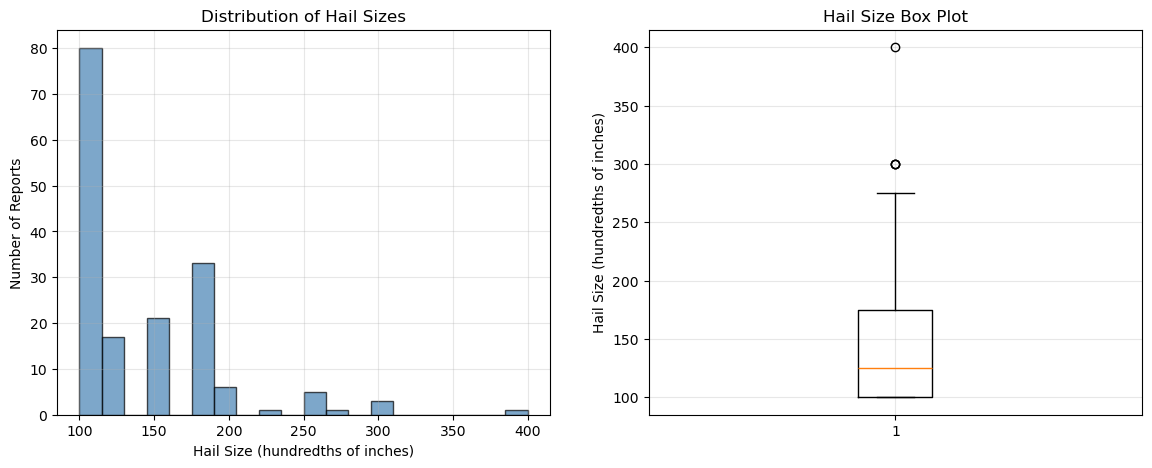

In [5]:
# Hail size distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['Size'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Hail Size (hundredths of inches)')
axes[0].set_ylabel('Number of Reports')
axes[0].set_title('Distribution of Hail Sizes')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df['Size'], vert=True)
axes[1].set_ylabel('Hail Size (hundredths of inches)')
axes[1].set_title('Hail Size Box Plot')
axes[1].grid(True, alpha=0.3)

plt.show()


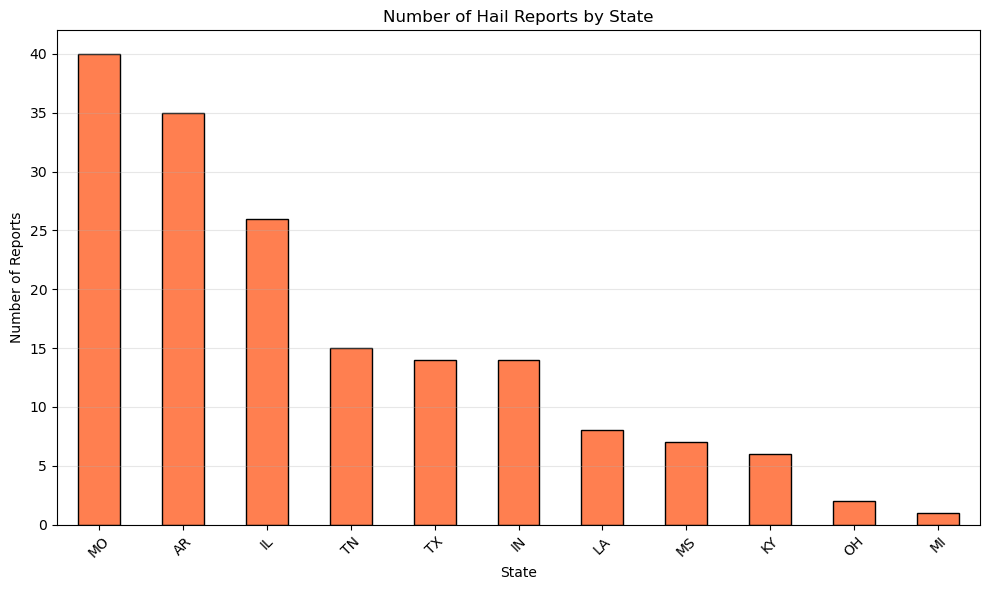

In [6]:
# Reports by state
state_counts = df['State'].value_counts()
plt.figure(figsize=(10, 6))
state_counts.plot(kind='bar', color='coral', edgecolor='black')
plt.xlabel('State')
plt.ylabel('Number of Reports')
plt.title('Number of Hail Reports by State')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


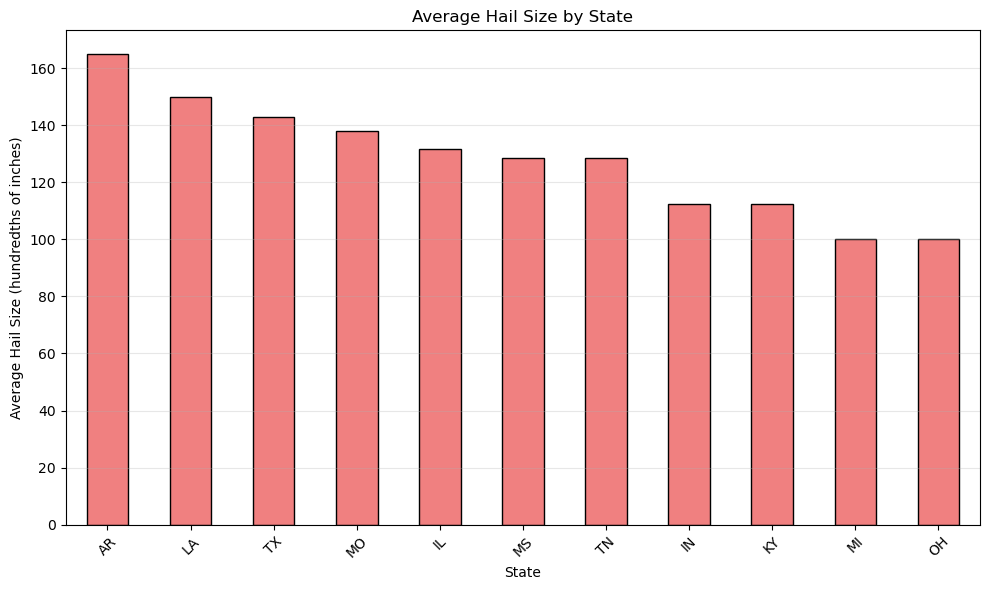

In [7]:
# Average hail size by state
avg_size_by_state = df.groupby('State')['Size'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
avg_size_by_state.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.xlabel('State')
plt.ylabel('Average Hail Size (hundredths of inches)')
plt.title('Average Hail Size by State')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


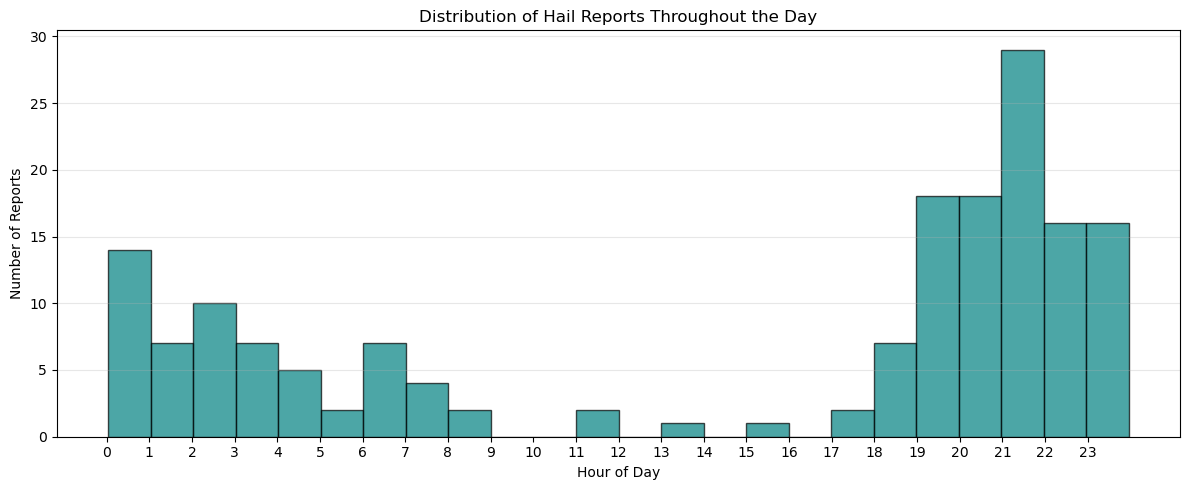

In [8]:
# Time analysis - convert time to datetime format
df['Time_str'] = df['Time'].astype(str).str.zfill(4)  # Pad with zeroes
df['Hour'] = df['Time_str'].str[:2].astype(int)
df['Minute'] = df['Time_str'].str[2:].astype(int)
df['Time_of_day'] = df['Hour'] + df['Minute']/60

# Plot reports by hour of day
plt.figure(figsize=(12, 5))
plt.hist(df['Time_of_day'], bins=24, edgecolor='black', alpha=0.7, color='teal')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Reports')
plt.title('Distribution of Hail Reports Throughout the Day')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


## Single Season (December 2024 - March 2025)

In [9]:
# Get all hail report files from stormreports_24 folder
hail_files = glob.glob('storm_reports/stormreports_24/*_hail.csv')
hail_files.sort()  # Sort by filename (which includes date)

print(f"Found {len(hail_files)} hail report files")

# Load and combine all hail reports
all_hail_reports = []
for file in hail_files:
    # Extract date from filename (format: YYMMDD_rpts_filtered_hail.csv)
    filename = os.path.basename(file)
    date_str = filename[:6]  # First 6 characters are YYMMDD
    
    # Parse date
    year = 2000 + int(date_str[:2])
    month = int(date_str[2:4])
    day = int(date_str[4:6])
    
    # Load the CSV
    df_day = pd.read_csv(file)
    
    # Add date information
    df_day['Date'] = pd.to_datetime(f'{year}-{month:02d}-{day:02d}')
    df_day['Year'] = year
    df_day['Month'] = month
    df_day['Day'] = day
    df_day['Filename'] = filename
    
    all_hail_reports.append(df_day)
    print(f"Loaded {filename}: {len(df_day)} reports")

# Combine all dataframes
df_season = pd.concat(all_hail_reports, ignore_index=True)

print(f"\nTotal hail reports for the season: {len(df_season)}")
print(f"Date range: {df_season['Date'].min()} to {df_season['Date'].max()}")


Found 38 hail report files
Loaded 241218_rpts_filtered_hail.csv: 3 reports
Loaded 241224_rpts_filtered_hail.csv: 13 reports
Loaded 241226_rpts_filtered_hail.csv: 3 reports
Loaded 241228_rpts_filtered_hail.csv: 14 reports
Loaded 241231_rpts_filtered_hail.csv: 7 reports
Loaded 250105_rpts_filtered_hail.csv: 1 reports
Loaded 250119_rpts_filtered_hail.csv: 1 reports
Loaded 250205_rpts_filtered_hail.csv: 2 reports
Loaded 250206_rpts_filtered_hail.csv: 10 reports
Loaded 250207_rpts_filtered_hail.csv: 1 reports
Loaded 250211_rpts_filtered_hail.csv: 1 reports
Loaded 250215_rpts_filtered_hail.csv: 12 reports
Loaded 250224_rpts_filtered_hail.csv: 1 reports
Loaded 250226_rpts_filtered_hail.csv: 2 reports
Loaded 250227_rpts_filtered_hail.csv: 4 reports
Loaded 250302_rpts_filtered_hail.csv: 1 reports
Loaded 250303_rpts_filtered_hail.csv: 16 reports
Loaded 250304_rpts_filtered_hail.csv: 3 reports
Loaded 250307_rpts_filtered_hail.csv: 14 reports
Loaded 250308_rpts_filtered_hail.csv: 12 reports
Loaded

### Season wide statistics:

In [10]:
print(f"Total reports: {len(df_season)}")
print(f"\nHail size statistics (in hundredths of inches):")
print(df_season['Size'].describe())
print(f"\nStates with reports:")
print(df_season['State'].value_counts())
print(f"\nReports by month:")
print(df_season['Month'].value_counts().sort_index())

Total reports: 724

Hail size statistics (in hundredths of inches):
count    724.000000
mean     129.792818
std       42.101092
min      100.000000
25%      100.000000
50%      100.000000
75%      150.000000
max      400.000000
Name: Size, dtype: float64

States with reports:
State
TX    172
MO    108
AR     60
IL     54
MS     43
TN     41
LA     36
IN     34
KY     33
OK     20
AL     20
IA     15
VA     10
KS     10
PA      9
NE      9
OH      7
MN      7
NC      6
GA      5
WI      5
SC      4
FL      4
WV      4
MI      2
MD      2
OR      1
DE      1
CA      1
WY      1
Name: count, dtype: int64

Reports by month:
Month
1       2
2      33
3     649
12     40
Name: count, dtype: int64


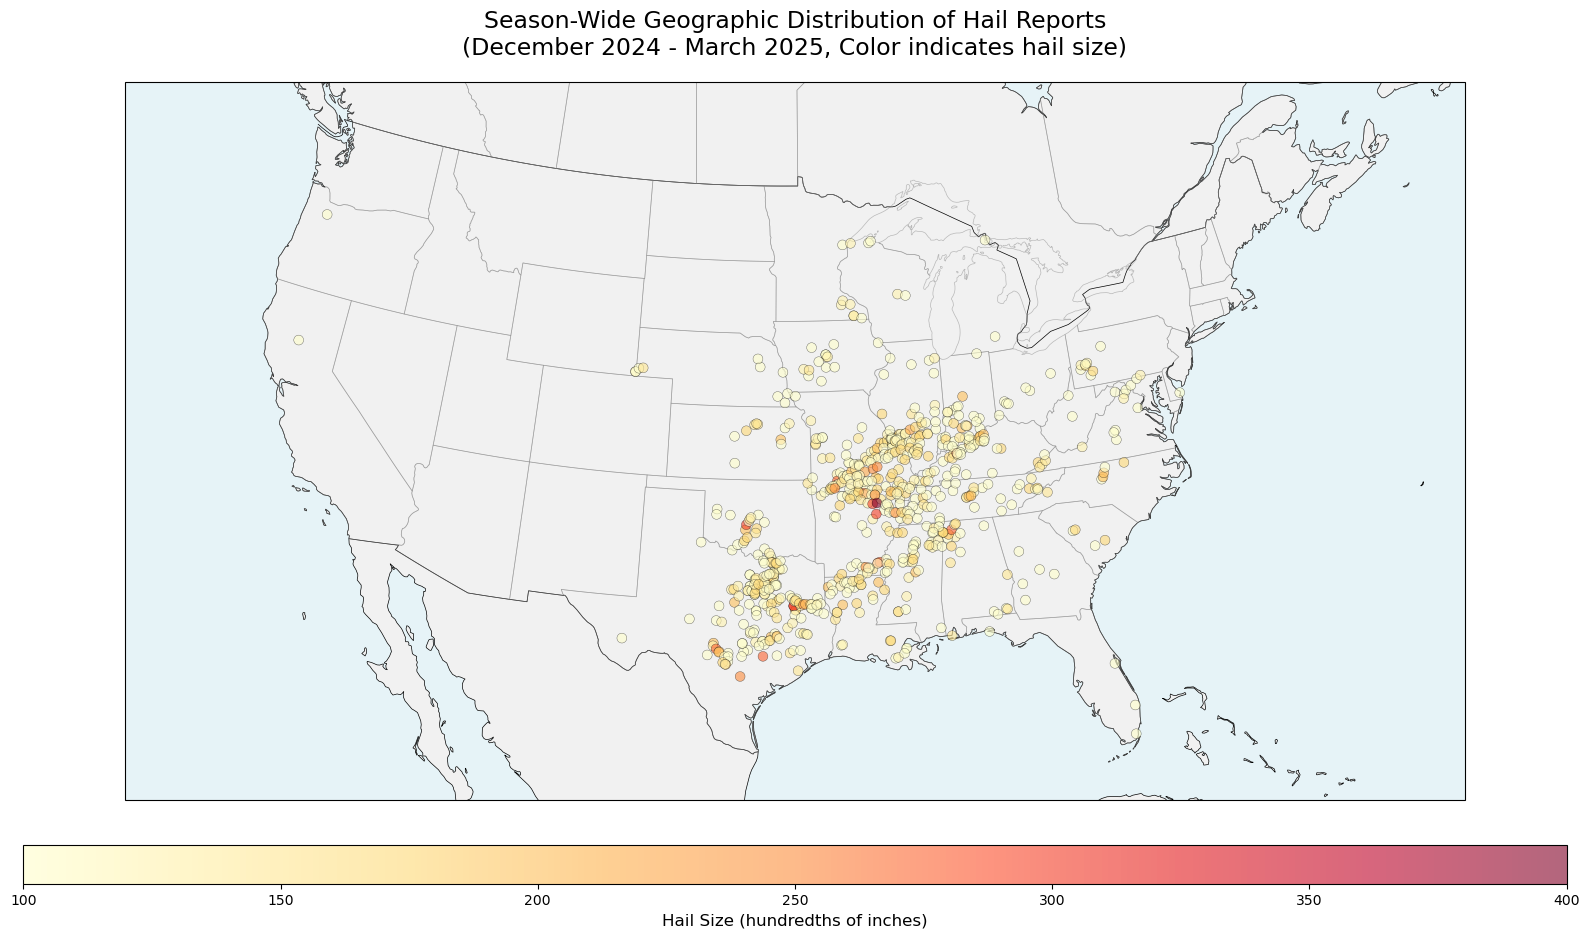

In [11]:
# Geographic scatter plot - Season-wide locations colored by hail size (Cartopy map)
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-96, central_latitude=37.5))

# Set extent to cover continental US
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Plot scatter points colored by hail size
scatter = ax.scatter(df_season['Lon'], df_season['Lat'], 
                    c=df_season['Size'], 
                    cmap='YlOrRd', s=50, alpha=0.6, 
                    edgecolors='black', linewidth=0.3,
                    transform=ccrs.PlateCarree(), zorder=10)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
cbar.set_label('Hail Size (hundredths of inches)', fontsize=12)

ax.set_title('Season-Wide Geographic Distribution of Hail Reports\n(December 2024 - March 2025, Color indicates hail size)', 
            fontsize=17, pad=20)
plt.tight_layout()
plt.show()


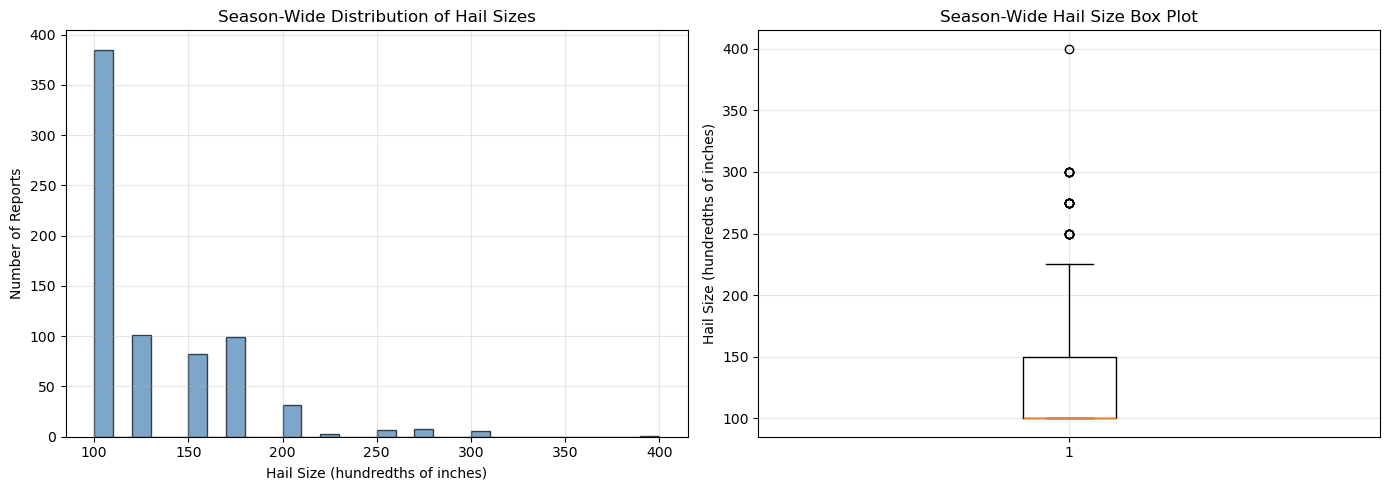

In [12]:
# Hail size distribution - Season-wide
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_season['Size'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Hail Size (hundredths of inches)')
axes[0].set_ylabel('Number of Reports')
axes[0].set_title('Season-Wide Distribution of Hail Sizes')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df_season['Size'], vert=True)
axes[1].set_ylabel('Hail Size (hundredths of inches)')
axes[1].set_title('Season-Wide Hail Size Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


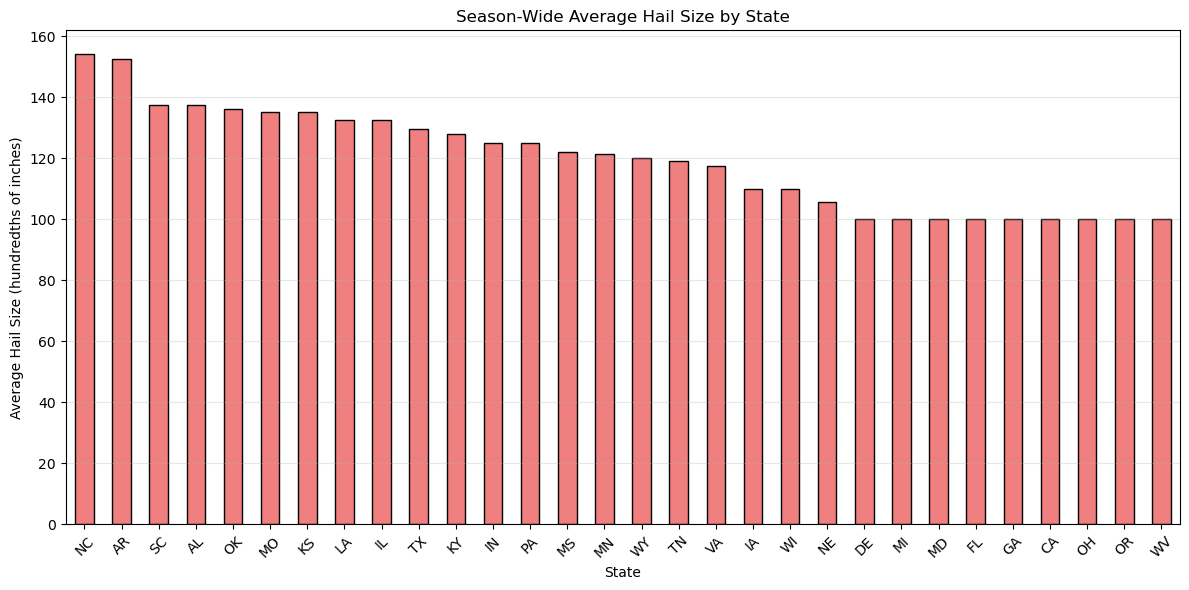

In [13]:
# Average hail size by state - Season-wide
avg_size_by_state = df_season.groupby('State')['Size'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
avg_size_by_state.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.xlabel('State')
plt.ylabel('Average Hail Size (hundredths of inches)')
plt.title('Season-Wide Average Hail Size by State')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


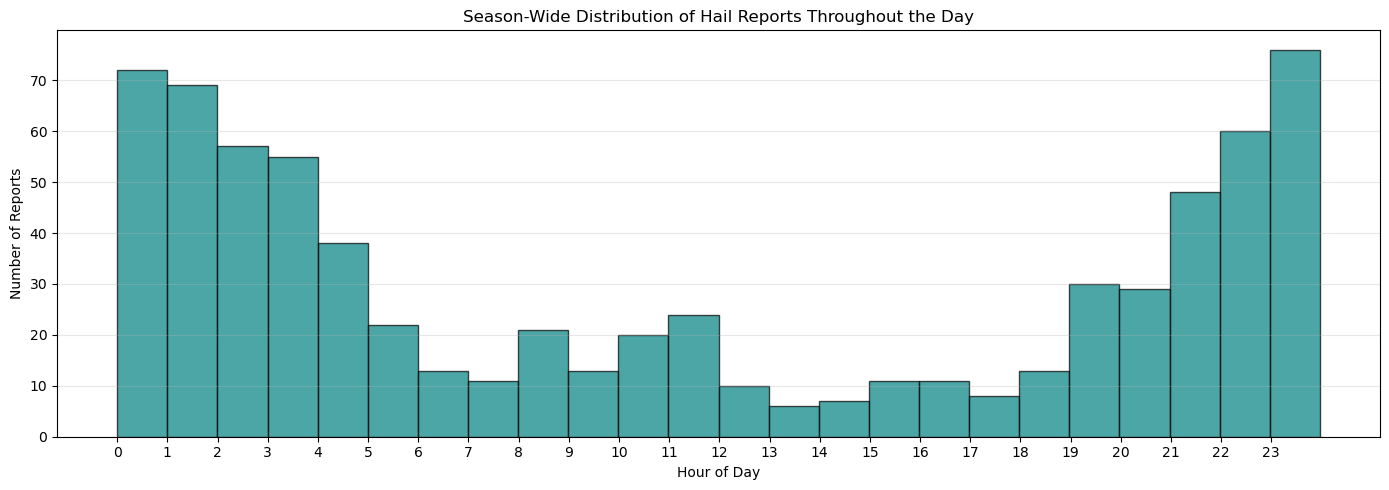

In [14]:
# Time analysis - Season-wide
# Convert time to datetime format
df_season['Time_str'] = df_season['Time'].astype(str).str.zfill(4)  # Pad with zeros
df_season['Hour'] = df_season['Time_str'].str[:2].astype(int)
df_season['Minute'] = df_season['Time_str'].str[2:].astype(int)
df_season['Time_of_day'] = df_season['Hour'] + df_season['Minute']/60

# Plot reports by hour of day
plt.figure(figsize=(14, 5))
plt.hist(df_season['Time_of_day'], bins=24, edgecolor='black', alpha=0.7, color='teal')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Reports')
plt.title('Season-Wide Distribution of Hail Reports Throughout the Day')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


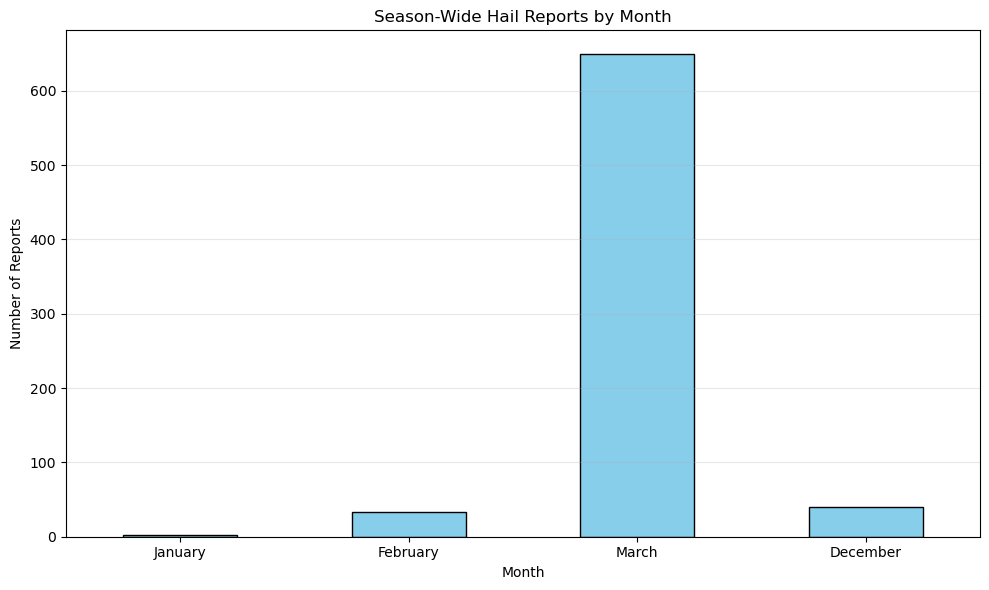

In [15]:
# Reports by month
month_counts = df_season.groupby('Month').size()
month_names = {12: 'December', 1: 'January', 2: 'February', 3: 'March'}
month_labels = [month_names[m] for m in month_counts.index]

plt.figure(figsize=(10, 6))
month_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Number of Reports')
plt.title('Season-Wide Hail Reports by Month')
plt.xticks(range(len(month_labels)), month_labels, rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


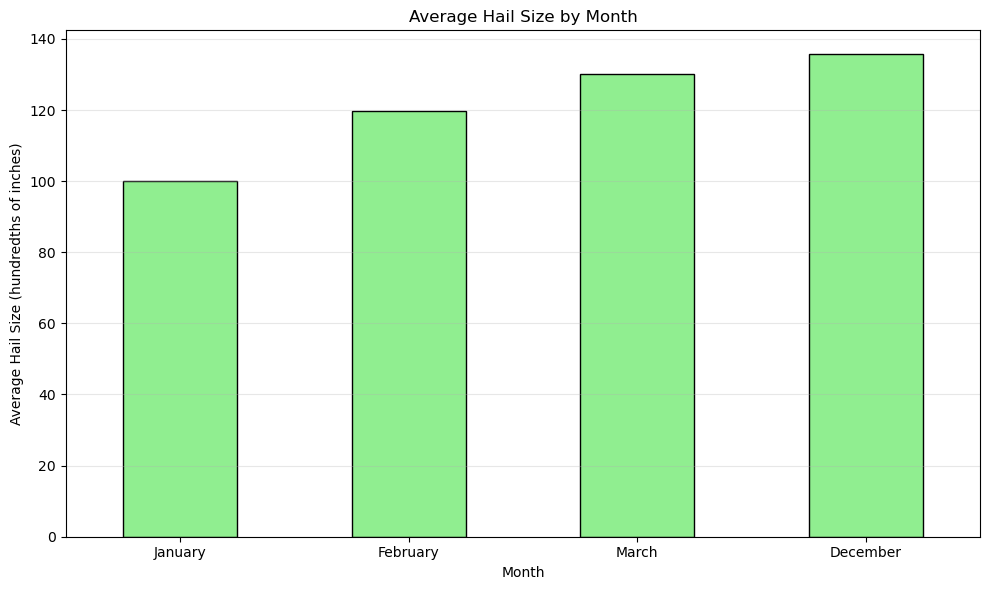

In [16]:
# Average hail size by month
avg_size_by_month = df_season.groupby('Month')['Size'].mean()
month_labels_avg = [month_names[m] for m in avg_size_by_month.index]

plt.figure(figsize=(10, 6))
avg_size_by_month.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Average Hail Size (hundredths of inches)')
plt.title('Average Hail Size by Month')
plt.xticks(range(len(month_labels_avg)), month_labels_avg, rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


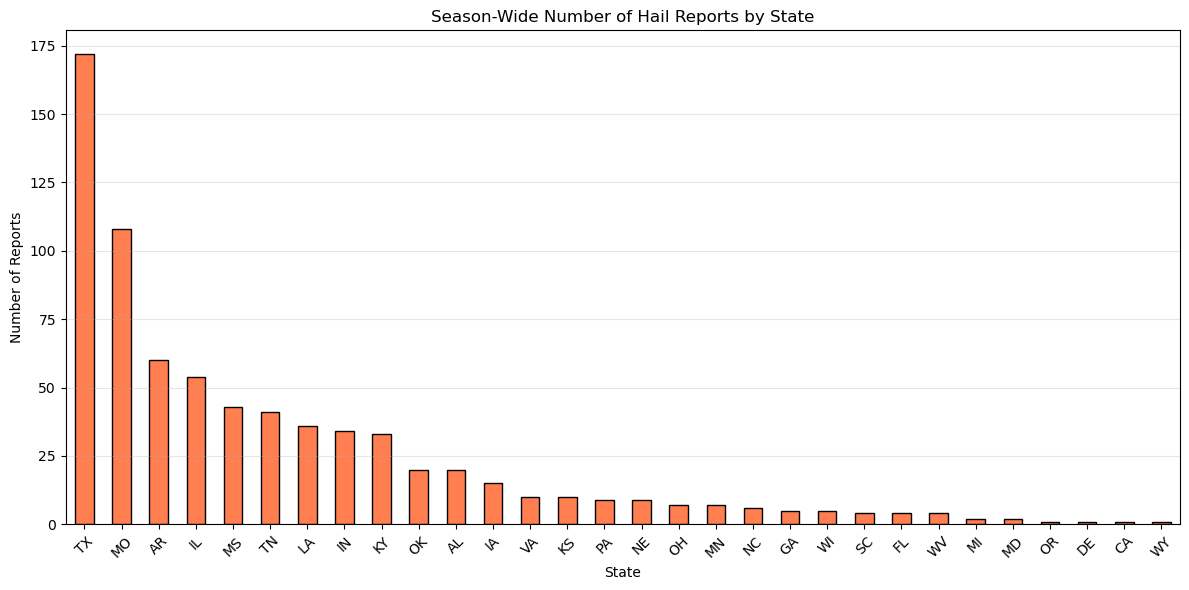

In [17]:
# Reports by state - Season-wide
state_counts = df_season['State'].value_counts()
plt.figure(figsize=(12, 6))
state_counts.plot(kind='bar', color='coral', edgecolor='black')
plt.xlabel('State')
plt.ylabel('Number of Reports')
plt.title('Season-Wide Number of Hail Reports by State')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [18]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader


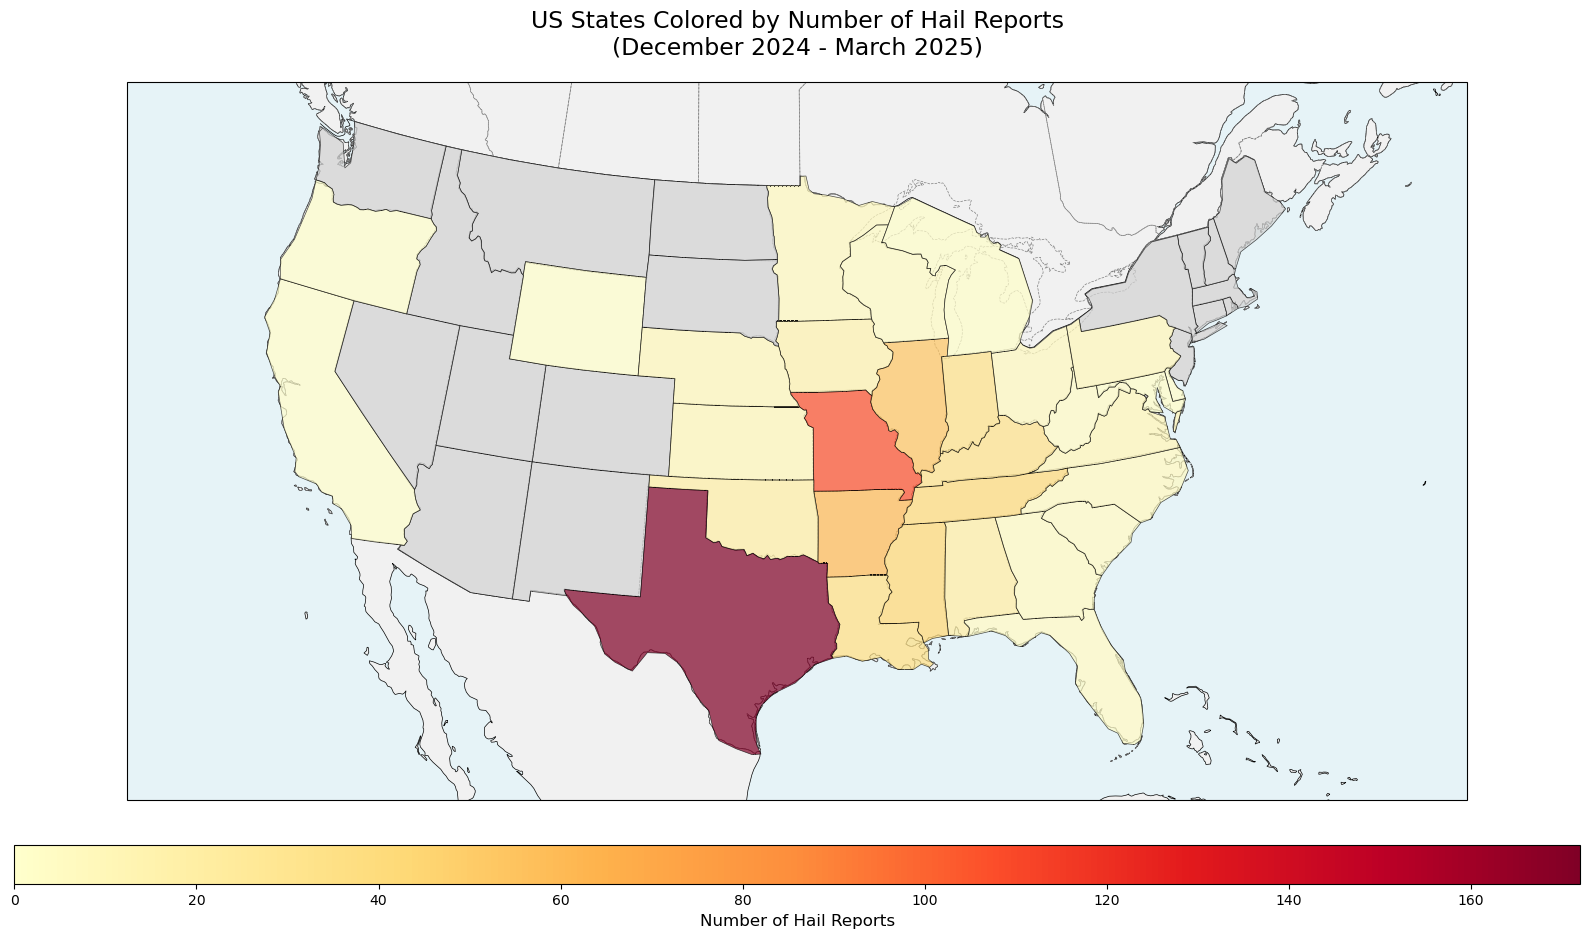

In [19]:
# Cartopy map: US states colored by number of hail reports
# Import shapereader (needed for Natural Earth data)
from cartopy.io import shapereader

# Get report counts by state
state_counts = df_season['State'].value_counts().to_dict()

# Calculate max reports and colormap before try block (needed in except block too)
max_reports = max(state_counts.values()) if state_counts else 1
cmap = plt.cm.YlOrRd

# Create the map
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-96, central_latitude=37.5))

# Set extent to cover continental US
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', linestyle='--')
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Get state boundaries from Natural Earth
try:
    # Try using Natural Earth states
    # Use full module path to avoid import issues
    import cartopy.io.shapereader as shapereader
    shpfilename = shapereader.natural_earth(resolution='110m', category='cultural', name='admin_1_states_provinces')
    reader = shapereader.Reader(shpfilename)
    states = reader.records()
    
    # State name mapping (Natural Earth uses full names, data uses abbreviations)
    state_abbrev_to_name = {
        'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
        'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
        'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
        'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
        'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
        'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
        'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
        'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
        'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
        'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
    }
    
    # Plot each state
    for state in states:
        state_name = state.attributes.get('name', '')
        state_abbrev = state.attributes.get('postal', '')
        
        # Try to match by abbreviation first, then by name
        report_count = 0
        if state_abbrev in state_counts:
            report_count = state_counts[state_abbrev]
        elif state_name in state_counts:
            report_count = state_counts[state_name]
        elif state_name in state_abbrev_to_name.values():
            # Find abbreviation from name
            for abbrev, name in state_abbrev_to_name.items():
                if name == state_name and abbrev in state_counts:
                    report_count = state_counts[abbrev]
                    break
        
        # Normalize count for coloring (0-1 range)
        if max_reports > 0:
            color_value = report_count / max_reports
        else:
            color_value = 0
        
        # Get color from colormap
        facecolor = cmap(color_value) if report_count > 0 else 'lightgray'
        
        # Plot the state
        ax.add_geometries([state.geometry], ccrs.PlateCarree(),
                         facecolor=facecolor, edgecolor='black', linewidth=0.5, alpha=0.7)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_reports))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Number of Hail Reports', fontsize=12)
    
    ax.set_title('US States Colored by Number of Hail Reports\n(December 2024 - March 2025)', 
                fontsize=17, pad=20)
    
except Exception as e:
    print(f"Error loading Natural Earth data: {e}")
    print("Falling back to simpler visualization...")
    
    # Fallback: Simple map with state boundaries from cartopy
    ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='black')
    
    # Add colorbar for fallback
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_reports))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Number of Hail Reports', fontsize=12)
    
    ax.set_title('US States Colored by Number of Hail Reports\n(December 2024 - March 2025)', 
                fontsize=14, pad=20)

plt.tight_layout()
plt.show()


## Multi-Season Analysis (2020-2024)


In [20]:
# Load all hail reports from all seasons (2020-2025)
# Define season folders
season_folders = ['stormreports_20', 'stormreports_21', 'stormreports_22', 
                  'stormreports_23', 'stormreports_24']

all_season_reports = []

for season_folder in season_folders:
    season_path = f'storm_reports/{season_folder}'
    
    # Check if folder exists
    if not os.path.exists(season_path):
        print(f"Warning: {season_path} not found, skipping...")
        continue
    
    # Get all hail report files from this season
    hail_files = glob.glob(f'{season_path}/*_hail.csv')
    hail_files.sort()
    
    # Extract season year from folder name (e.g., stormreports_23 -> 2023, which is Dec 2023)
    # Folder number is the year of December, so stormreports_23 = 2023-2024 season
    season_year = 2000 + int(season_folder[-2:])
    
    print(f"\nProcessing {season_folder} (season {season_year}-{season_year+1}):")
    print(f"  Found {len(hail_files)} hail report files")
    
    season_reports = []
    for file in hail_files:
        # Extract date from filename (format: YYMMDD_rpts_filtered_hail.csv)
        filename = os.path.basename(file)
        date_str = filename[:6]  # First 6 characters are YYMMDD
        
        # Parse date
        year = 2000 + int(date_str[:2])
        month = int(date_str[2:4])
        day = int(date_str[4:6])
        
        # Load the CSV
        try:
            df_day = pd.read_csv(file)
            
            # Add date and season information
            df_day['Date'] = pd.to_datetime(f'{year}-{month:02d}-{day:02d}')
            df_day['Year'] = year
            df_day['Month'] = month
            df_day['Day'] = day
            df_day['Season'] = season_year  # Season year is the December year (e.g., stormreports_23 = 2023-2024 season)
            df_day['Season_Label'] = f'{season_year}-{season_year+1}'
            df_day['Filename'] = filename
            
            season_reports.append(df_day)
        except Exception as e:
            print(f"    Error loading {filename}: {e}")
            continue
    
    if season_reports:
        df_season = pd.concat(season_reports, ignore_index=True)
        all_season_reports.append(df_season)
        print(f"  Total reports: {len(df_season)}")
        print(f"  Date range: {df_season['Date'].min()} to {df_season['Date'].max()}")

# Combine all seasons
if all_season_reports:
    df_all_seasons = pd.concat(all_season_reports, ignore_index=True)
    
    print(f"\n{'='*60}")
    print(f"TOTAL ACROSS ALL SEASONS:")
    print(f"Total hail reports: {len(df_all_seasons)}")
    print(f"Date range: {df_all_seasons['Date'].min()} to {df_all_seasons['Date'].max()}")
    print(f"Seasons covered: {sorted(df_all_seasons['Season'].unique())}")
    print(f"{'='*60}")
else:
    print("No data loaded!")



Processing stormreports_20 (season 2020-2021):
  Found 28 hail report files
  Total reports: 420
  Date range: 2021-01-06 00:00:00 to 2021-03-31 00:00:00

Processing stormreports_21 (season 2021-2022):
  Found 30 hail report files
  Total reports: 259
  Date range: 2021-12-05 00:00:00 to 2022-03-31 00:00:00

Processing stormreports_22 (season 2022-2023):
  Found 38 hail report files
  Total reports: 635
  Date range: 2022-12-10 00:00:00 to 2023-03-31 00:00:00

Processing stormreports_23 (season 2023-2024):
  Found 45 hail report files
  Total reports: 856
  Date range: 2023-12-01 00:00:00 to 2024-03-31 00:00:00

Processing stormreports_24 (season 2024-2025):
  Found 38 hail report files
  Total reports: 724
  Date range: 2024-12-18 00:00:00 to 2025-03-31 00:00:00

TOTAL ACROSS ALL SEASONS:
Total hail reports: 2894
Date range: 2021-01-06 00:00:00 to 2025-03-31 00:00:00
Seasons covered: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


In [21]:
# Multi-season statistics
print(f"Total reports across all seasons: {len(df_all_seasons)}")
print(f"\nHail size statistics (in hundredths of inches):")
print(df_all_seasons['Size'].describe())
print(f"\nStates with reports:")
print(df_all_seasons['State'].value_counts())
print(f"\nReports by season:")
print(df_all_seasons.groupby('Season_Label').size().sort_index())
print(f"\nReports by month (across all seasons):")
print(df_all_seasons['Month'].value_counts().sort_index())


Total reports across all seasons: 2894

Hail size statistics (in hundredths of inches):
count    2894.000000
mean      132.683829
std        47.295994
min       100.000000
25%       100.000000
50%       100.000000
75%       150.000000
max       525.000000
Name: Size, dtype: float64

States with reports:
State
TX    594
MO    330
IL    217
MS    179
AR    176
OK    173
TN    145
LA    123
IN    120
GA    118
AL    116
KS     98
KY     88
IA     81
FL     62
OH     59
NC     33
NE     27
SC     26
VA     26
WV     23
WI     18
MI     13
PA     12
CA     12
MN     10
NJ      4
MD      3
SD      2
NM      2
NV      1
DE      1
OR      1
WY      1
Name: count, dtype: int64

Reports by season:
Season_Label
2020-2021    420
2021-2022    259
2022-2023    635
2023-2024    856
2024-2025    724
dtype: int64

Reports by month (across all seasons):
Month
1      138
2      313
3     2246
12     197
Name: count, dtype: int64


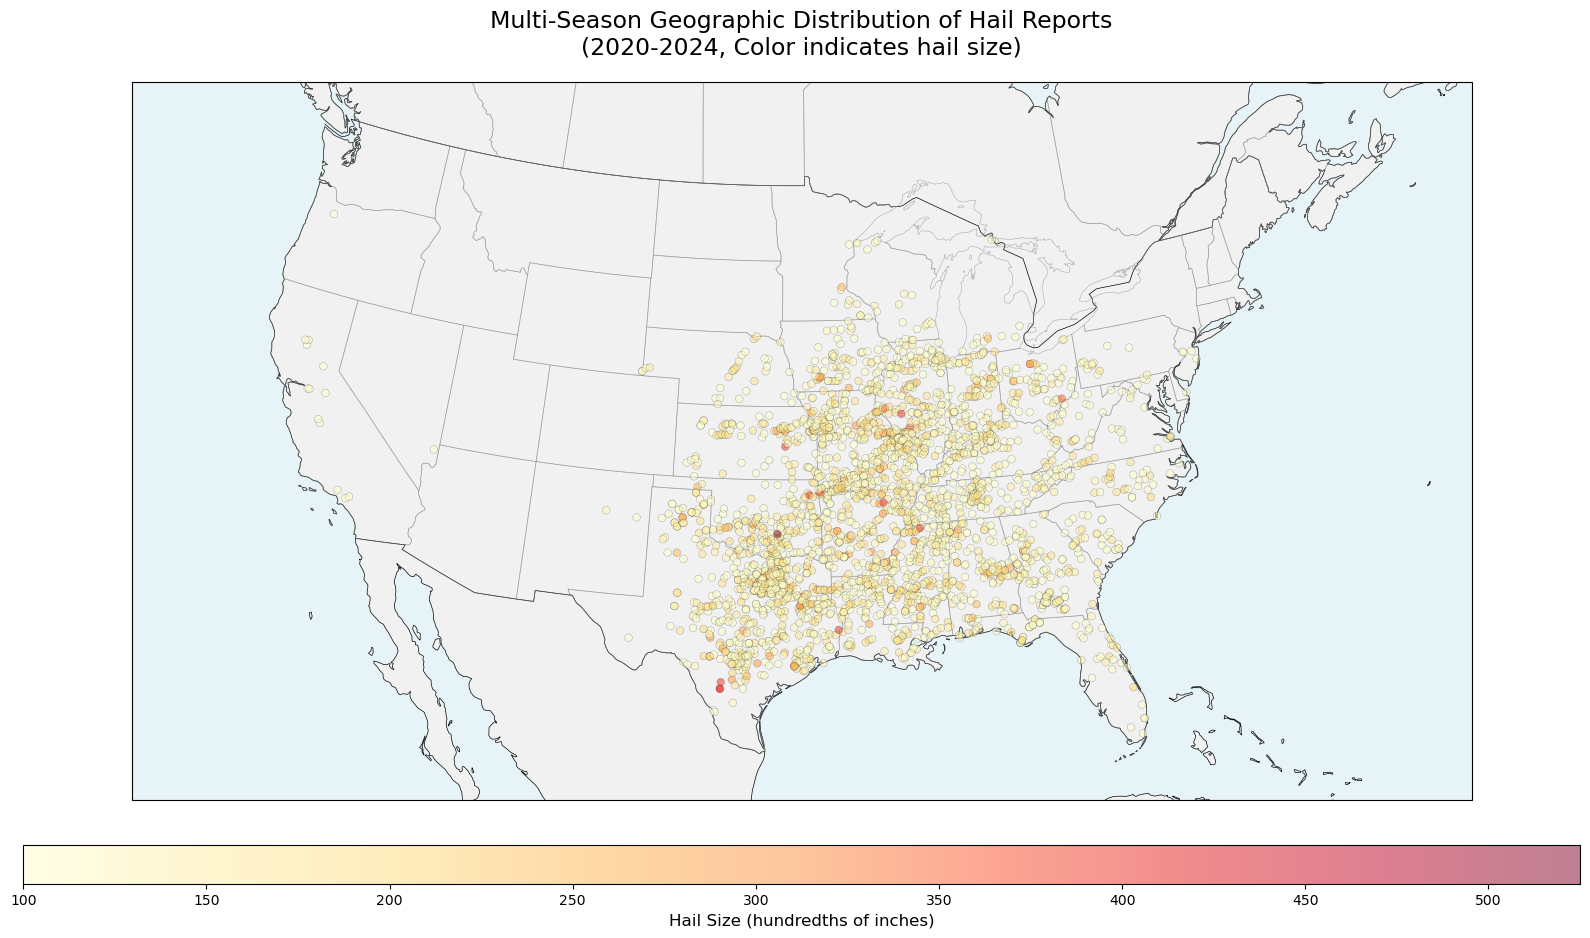

In [22]:
# Geographic scatter plot - All seasons locations colored by hail size (Cartopy map)
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-96, central_latitude=37.5))

# Set extent to cover continental US
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Plot scatter points colored by hail size
scatter = ax.scatter(df_all_seasons['Lon'], df_all_seasons['Lat'], 
                    c=df_all_seasons['Size'], 
                    cmap='YlOrRd', s=30, alpha=0.5, 
                    edgecolors='black', linewidth=0.2,
                    transform=ccrs.PlateCarree(), zorder=10)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
cbar.set_label('Hail Size (hundredths of inches)', fontsize=12)

ax.set_title('Multi-Season Geographic Distribution of Hail Reports\n(2020-2024, Color indicates hail size)', 
            fontsize=17, pad=20)
plt.tight_layout()
plt.show()


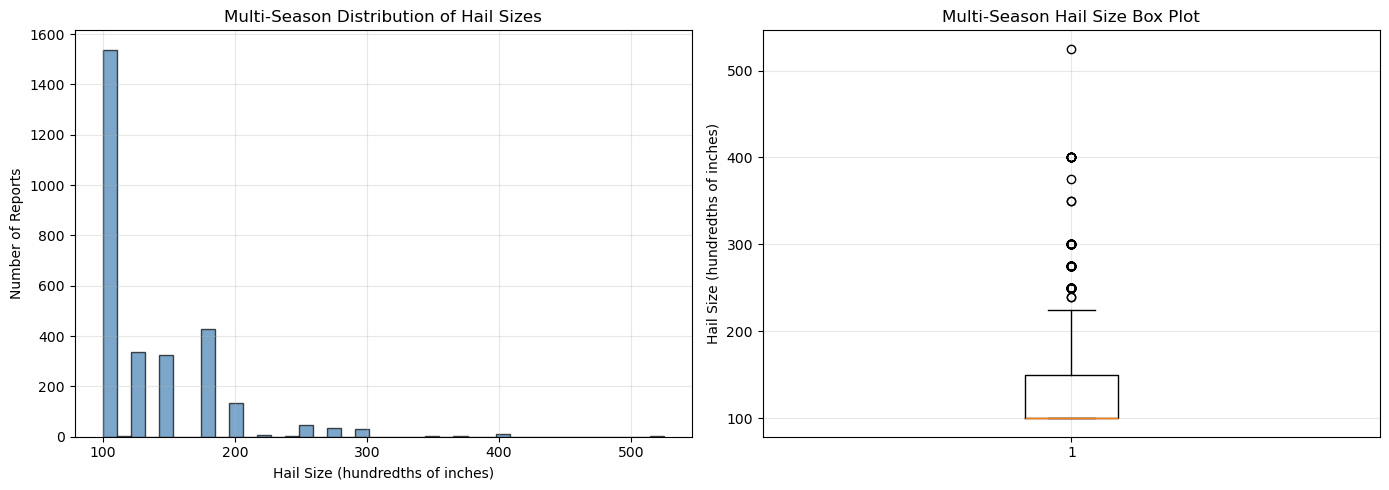

In [23]:
# Hail size distribution - All seasons
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_all_seasons['Size'], bins=40, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Hail Size (hundredths of inches)')
axes[0].set_ylabel('Number of Reports')
axes[0].set_title('Multi-Season Distribution of Hail Sizes')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df_all_seasons['Size'], vert=True)
axes[1].set_ylabel('Hail Size (hundredths of inches)')
axes[1].set_title('Multi-Season Hail Size Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


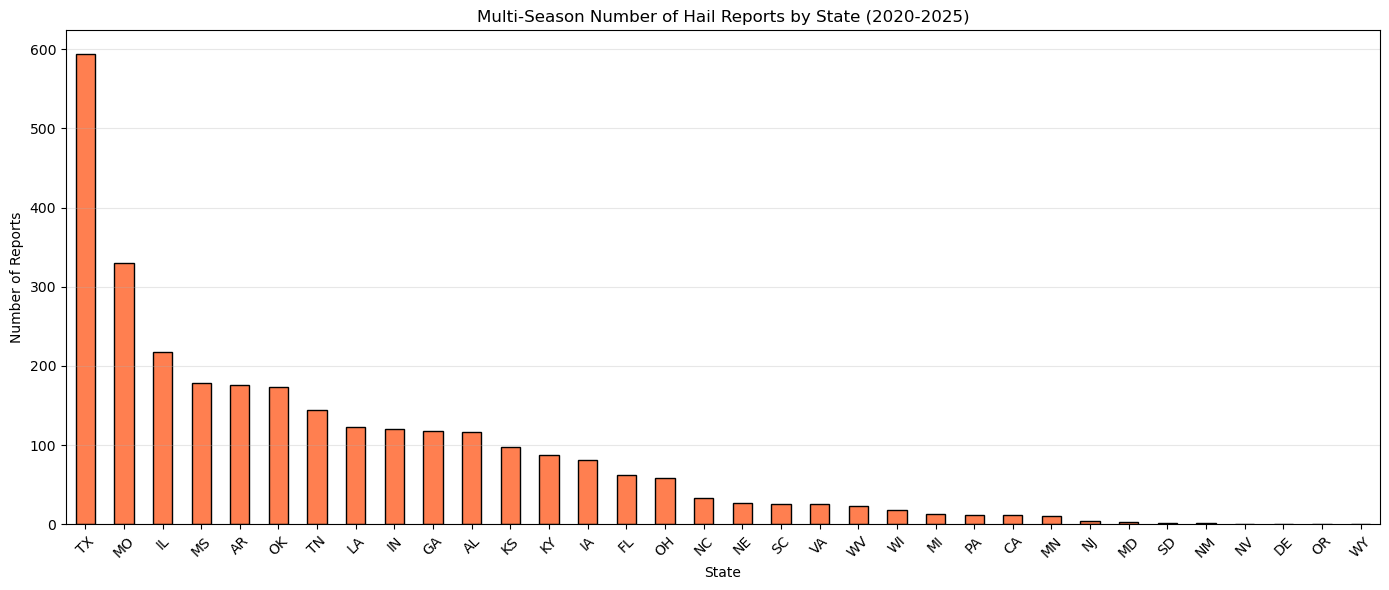

In [24]:
# Reports by state - All seasons
state_counts = df_all_seasons['State'].value_counts()
plt.figure(figsize=(14, 6))
state_counts.plot(kind='bar', color='coral', edgecolor='black')
plt.xlabel('State')
plt.ylabel('Number of Reports')
plt.title('Multi-Season Number of Hail Reports by State (2020-2025)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


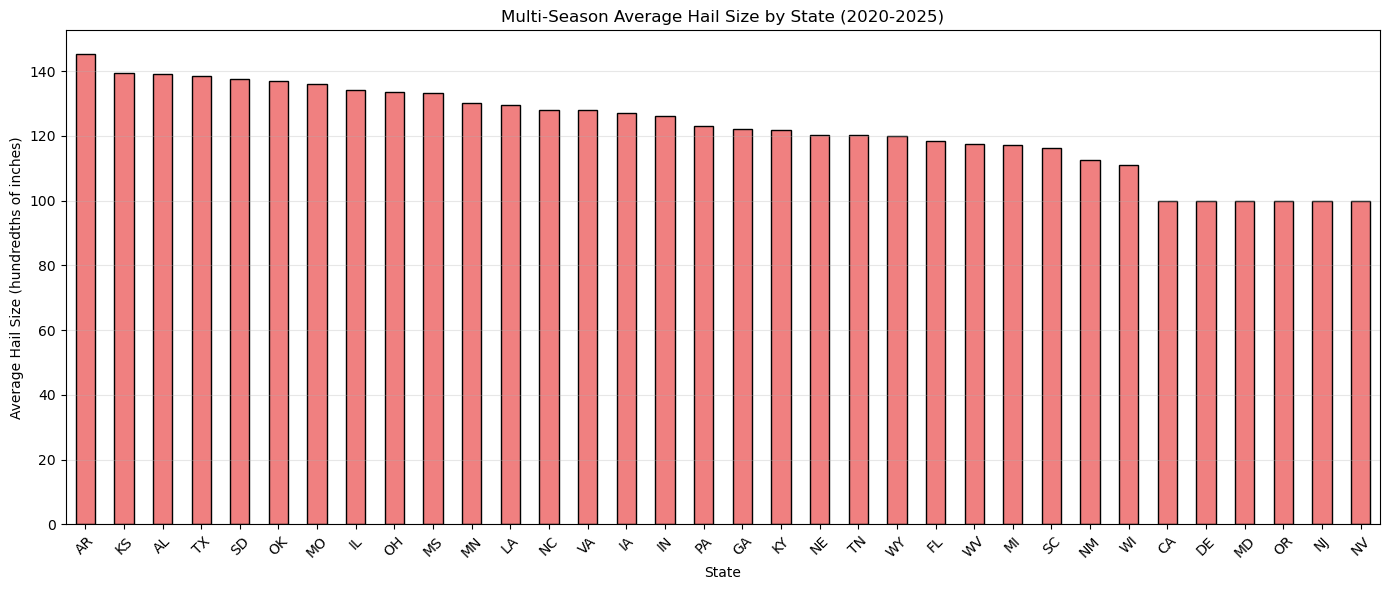

In [25]:
# Average hail size by state - All seasons
avg_size_by_state = df_all_seasons.groupby('State')['Size'].mean().sort_values(ascending=False)
plt.figure(figsize=(14, 6))
avg_size_by_state.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.xlabel('State')
plt.ylabel('Average Hail Size (hundredths of inches)')
plt.title('Multi-Season Average Hail Size by State (2020-2025)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


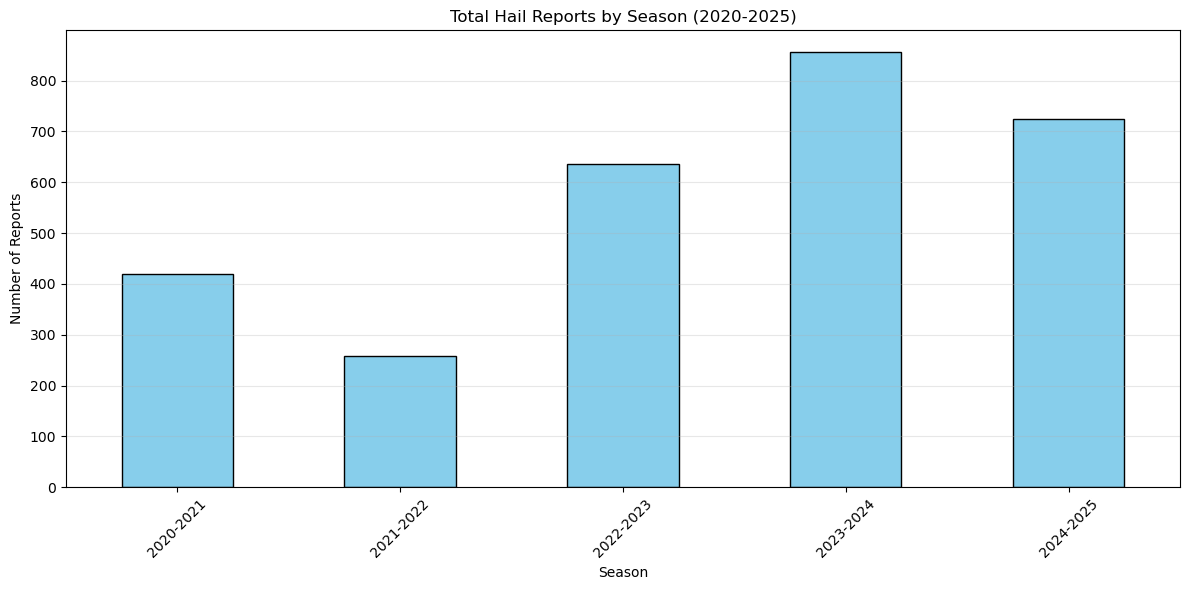

In [26]:
# Reports by season
season_counts = df_all_seasons.groupby('Season_Label').size().sort_index()
plt.figure(figsize=(12, 6))
season_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Season')
plt.ylabel('Number of Reports')
plt.title('Total Hail Reports by Season (2020-2025)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


In [27]:
season_counts

Season_Label
2020-2021    420
2021-2022    259
2022-2023    635
2023-2024    856
2024-2025    724
dtype: int64

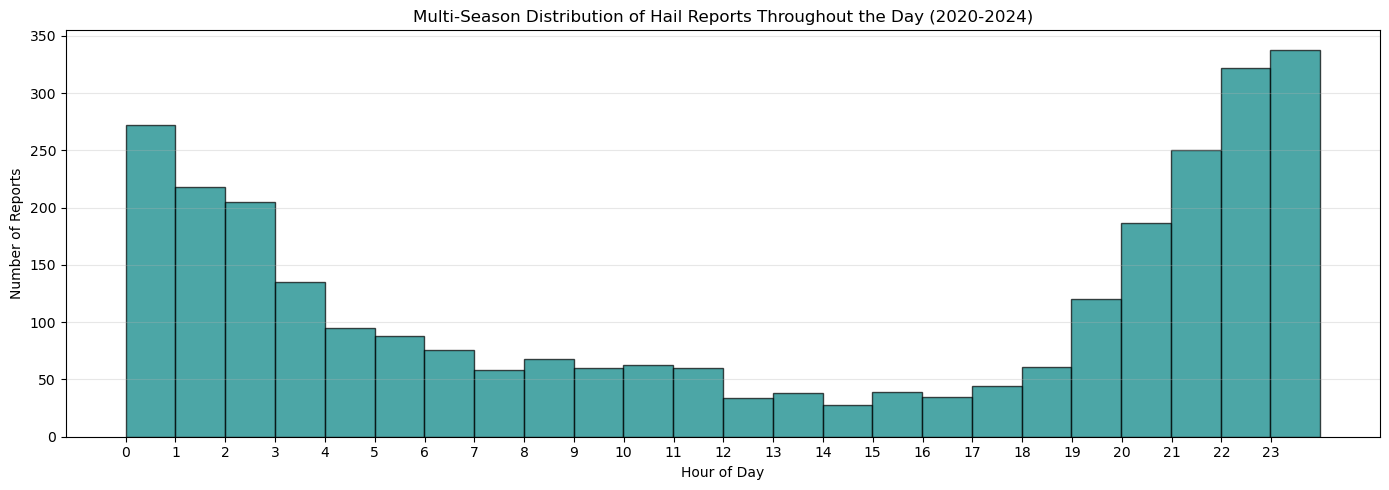

In [28]:
# Time analysis - All seasons
# Convert time to datetime format
df_all_seasons['Time_str'] = df_all_seasons['Time'].astype(str).str.zfill(4)  # Pad with zeros
df_all_seasons['Hour'] = df_all_seasons['Time_str'].str[:2].astype(int)
df_all_seasons['Minute'] = df_all_seasons['Time_str'].str[2:].astype(int)
df_all_seasons['Time_of_day'] = df_all_seasons['Hour'] + df_all_seasons['Minute']/60

# Plot reports by hour of day
plt.figure(figsize=(14, 5))
plt.hist(df_all_seasons['Time_of_day'], bins=24, edgecolor='black', alpha=0.7, color='teal')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Reports')
plt.title('Multi-Season Distribution of Hail Reports Throughout the Day (2020-2024)')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


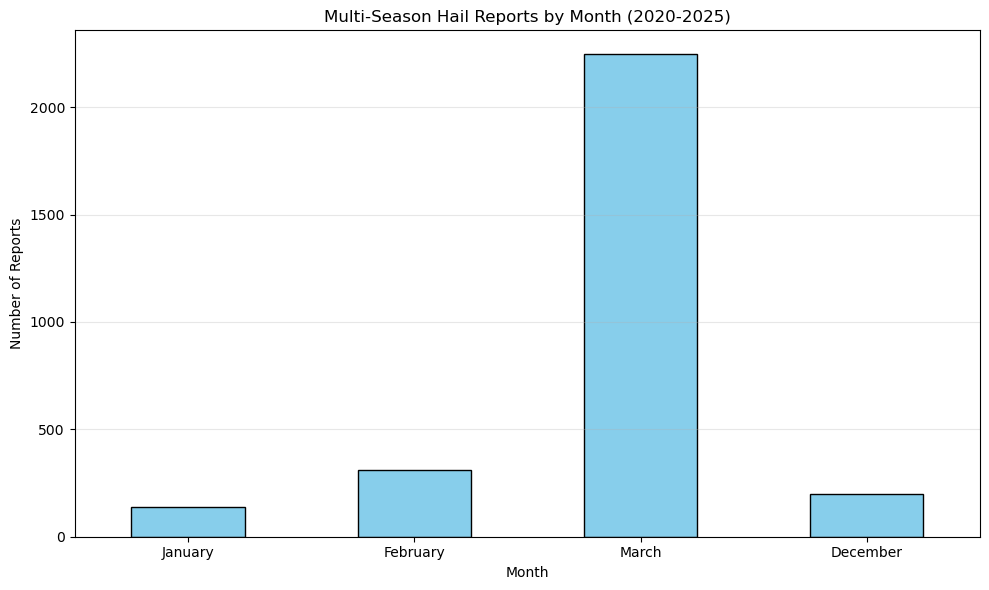

In [29]:
# Reports by month (across all seasons)
month_counts = df_all_seasons.groupby('Month').size()
month_names = {12: 'December', 1: 'January', 2: 'February', 3: 'March'}
month_labels = [month_names.get(m, f'Month {m}') for m in month_counts.index]

plt.figure(figsize=(10, 6))
month_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Number of Reports')
plt.title('Multi-Season Hail Reports by Month (2020-2025)')
plt.xticks(range(len(month_labels)), month_labels, rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


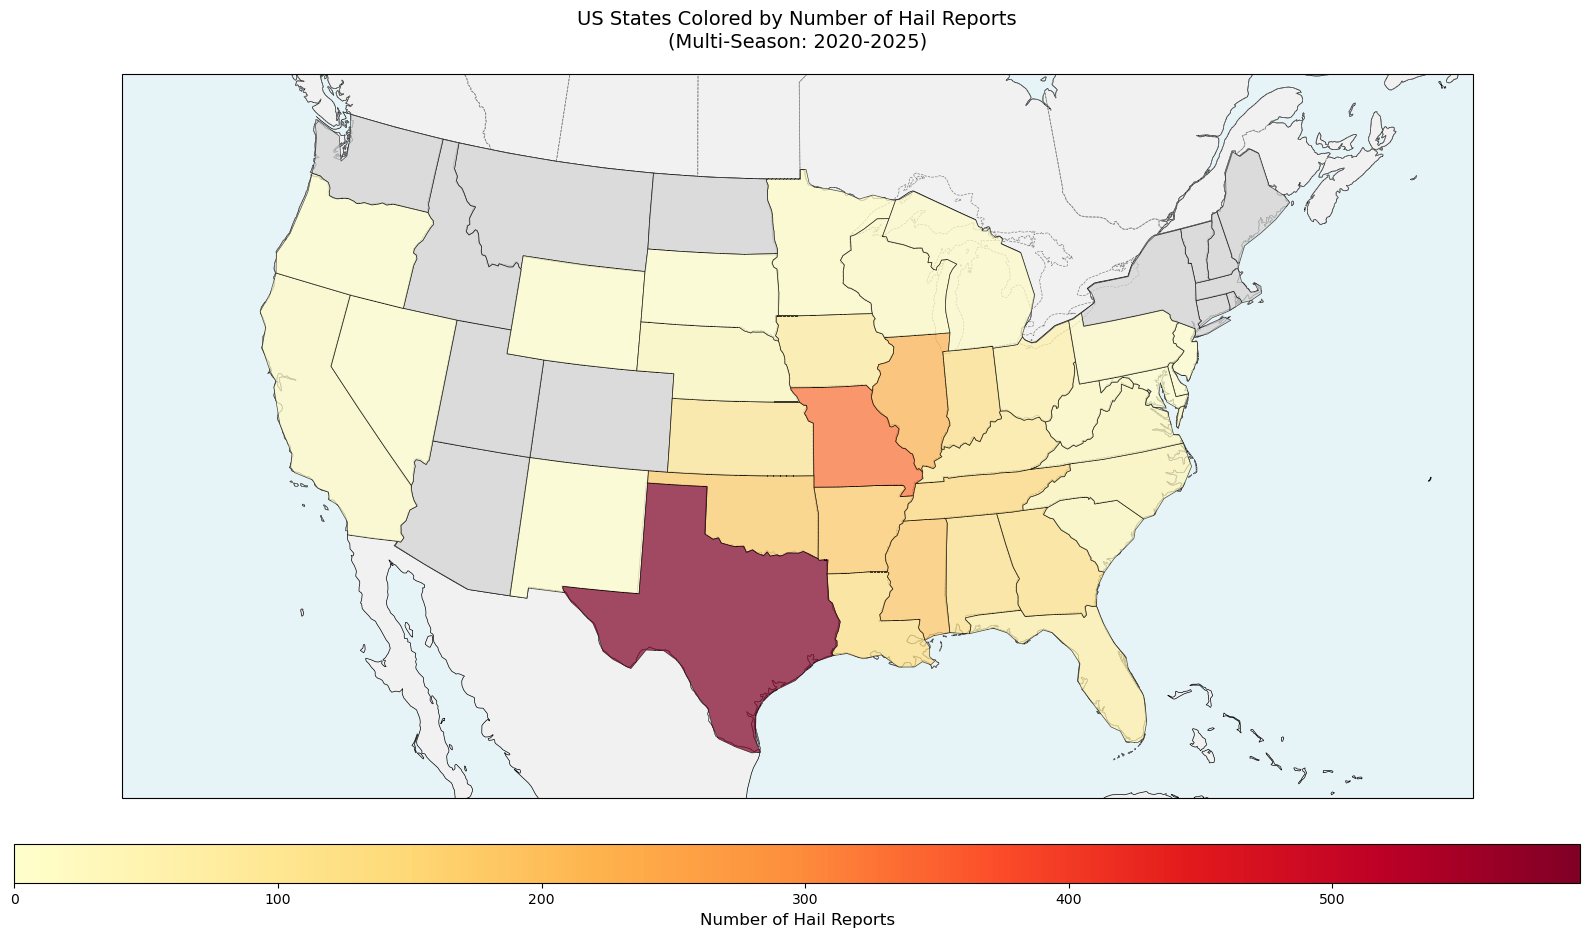

In [30]:
# Cartopy map: US states colored by number of hail reports (All seasons)
from cartopy.io import shapereader

# Get report counts by state
state_counts = df_all_seasons['State'].value_counts().to_dict()

# Calculate max reports and colormap before try block (needed in except block too)
max_reports = max(state_counts.values()) if state_counts else 1
cmap = plt.cm.YlOrRd

# Create the map
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-96, central_latitude=37.5))

# Set extent to cover continental US
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', linestyle='--')
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Get state boundaries from Natural Earth
try:
    # Try using Natural Earth states
    # Use full module path to avoid import issues
    import cartopy.io.shapereader as shapereader
    shpfilename = shapereader.natural_earth(resolution='110m', category='cultural', name='admin_1_states_provinces')
    reader = shapereader.Reader(shpfilename)
    states = reader.records()
    
    # State name mapping (Natural Earth uses full names, data uses abbreviations)
    state_abbrev_to_name = {
        'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
        'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
        'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
        'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
        'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
        'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
        'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
        'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
        'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
        'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
    }
    
    # Plot each state
    for state in states:
        state_name = state.attributes.get('name', '')
        state_abbrev = state.attributes.get('postal', '')
        
        # Try to match by abbreviation first, then by name
        report_count = 0
        if state_abbrev in state_counts:
            report_count = state_counts[state_abbrev]
        elif state_name in state_counts:
            report_count = state_counts[state_name]
        elif state_name in state_abbrev_to_name.values():
            # Find abbreviation from name
            for abbrev, name in state_abbrev_to_name.items():
                if name == state_name and abbrev in state_counts:
                    report_count = state_counts[abbrev]
                    break
        
        # Normalize count for coloring (0-1 range)
        if max_reports > 0:
            color_value = report_count / max_reports
        else:
            color_value = 0
        
        # Get color from colormap
        facecolor = cmap(color_value) if report_count > 0 else 'lightgray'
        
        # Plot the state
        ax.add_geometries([state.geometry], ccrs.PlateCarree(),
                         facecolor=facecolor, edgecolor='black', linewidth=0.5, alpha=0.7)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_reports))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Number of Hail Reports', fontsize=12)
    
    ax.set_title('US States Colored by Number of Hail Reports\n(Multi-Season: 2020-2025)', 
                fontsize=14, pad=20)
    
except Exception as e:
    print(f"Error loading Natural Earth data: {e}")
    print("Falling back to simpler visualization...")
    
    # Fallback: Simple map with state boundaries from cartopy
    ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='black')
    
    # Add colorbar for fallback
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_reports))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Number of Hail Reports', fontsize=12)
    
    ax.set_title('US States Colored by Number of Hail Reports\n(Multi-Season: 2020-2024)', 
                fontsize=14, pad=20)

plt.tight_layout()
plt.show()


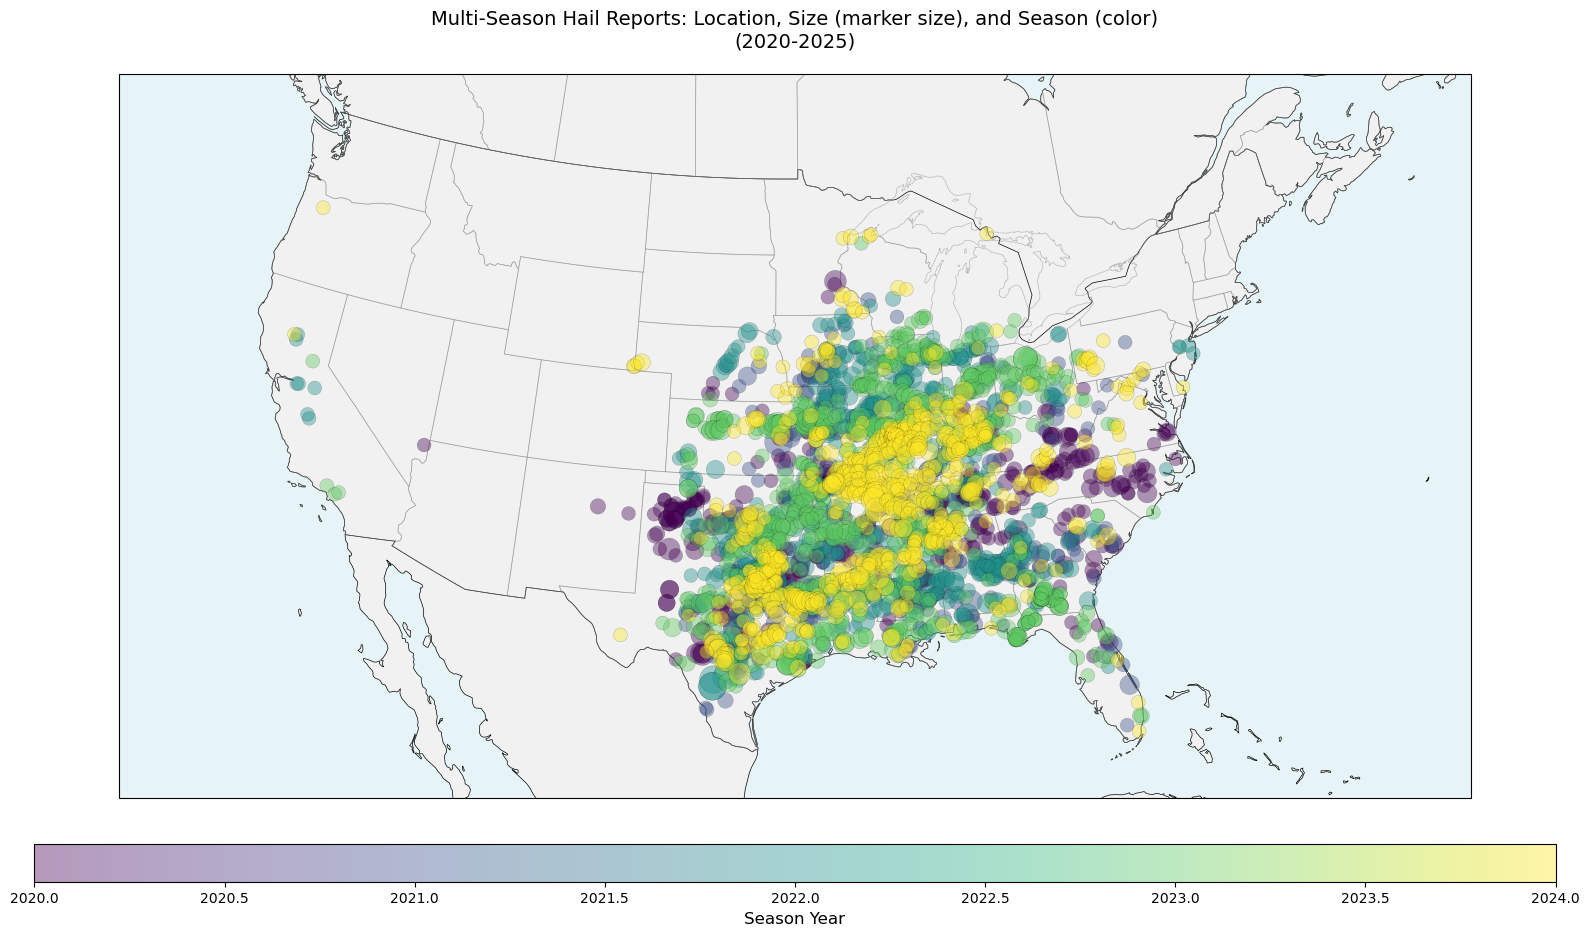

In [31]:
# Geographic plot with size as marker size and season as color - All seasons
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-96, central_latitude=37.5))

# Set extent to cover continental US
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Create a numeric season value for coloring
season_numeric = df_all_seasons['Season'].values

# Plot scatter points with size proportional to hail size and color by season
scatter = ax.scatter(df_all_seasons['Lon'], df_all_seasons['Lat'], 
                    s=df_all_seasons['Size']*1.0, 
                    c=season_numeric, cmap='viridis', 
                    alpha=0.4, edgecolors='black', linewidth=0.2,
                    transform=ccrs.PlateCarree(), zorder=10)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
cbar.set_label('Season Year', fontsize=12)

ax.set_title('Multi-Season Hail Reports: Location, Size (marker size), and Season (color)\n(2020-2025)', 
            fontsize=14, pad=20)
plt.tight_layout()
plt.show()


Plot above might be unnecessary

## 2015-2024 Seasons (Decade-long Analysis)

In [32]:
# Load all storm reports (hail, tornado, wind) from all seasons (2015-2024)
# Define season folders
season_folders = ['stormreports_15','stormreports_16','stormreports_17','stormreports_18','stormreports_19',
                'stormreports_20', 'stormreports_21', 'stormreports_22', 
                  'stormreports_23', 'stormreports_24']

# Separate lists for each report type
all_hail_reports = []
all_tornado_reports = []
all_wind_reports = []

for season_folder in season_folders:
    season_path = f'storm_reports/{season_folder}'
    
    # Check if folder exists
    if not os.path.exists(season_path):
        print(f"Warning: {season_path} not found, skipping...")
        continue
    
    # Extract season year from folder name (e.g., stormreports_23 -> 2023, which is Dec 2023)
    # Folder number is the year of December, so stormreports_23 = 2023-2024 season
    season_year = 2000 + int(season_folder[-2:])
    
    print(f"\nProcessing {season_folder} (season {season_year}-{season_year+1}):")
    
    # Process each report type
    for report_type in ['hail', 'torn', 'wind']:
        # Get all report files for this type
        if report_type == 'torn':
            pattern = f'{season_path}/*_torn.csv'
        else:
            pattern = f'{season_path}/*_{report_type}.csv'
        
        report_files = glob.glob(pattern)
        report_files.sort()
        
        if not report_files:
            continue
            
        print(f"  Found {len(report_files)} {report_type} report files")
        
        type_reports = []
        for file in report_files:
            # Extract date from filename (format: YYMMDD_rpts_filtered_[type].csv)
            filename = os.path.basename(file)
            date_str = filename[:6]  # First 6 characters are YYMMDD
            
            # Parse date
            year = 2000 + int(date_str[:2])
            month = int(date_str[2:4])
            day = int(date_str[4:6])
            
            # Load the CSV
            try:
                df_day = pd.read_csv(file)
                
                # Add date and season information
                df_day['Date'] = pd.to_datetime(f'{year}-{month:02d}-{day:02d}')
                df_day['Year'] = year
                df_day['Month'] = month
                df_day['Day'] = day
                df_day['Season'] = season_year  # Season year is the December year
                df_day['Season_Label'] = f'{season_year}-{season_year+1}'
                df_day['Report_Type'] = report_type  # Add report type identifier
                df_day['Filename'] = filename
                
                type_reports.append(df_day)
            except Exception as e:
                print(f"    Error loading {filename}: {e}")
                continue
        
        if type_reports:
            df_season_type = pd.concat(type_reports, ignore_index=True)
            
            # Add to appropriate list
            if report_type == 'hail':
                all_hail_reports.append(df_season_type)
            elif report_type == 'torn':
                all_tornado_reports.append(df_season_type)
            elif report_type == 'wind':
                all_wind_reports.append(df_season_type)
            
            print(f"    Total {report_type} reports: {len(df_season_type)}")
            print(f"    Date range: {df_season_type['Date'].min()} to {df_season_type['Date'].max()}")

# Combine all seasons for each report type
if all_hail_reports:
    df_all_hail = pd.concat(all_hail_reports, ignore_index=True)
    print(f"\n{'='*60}")
    print(f"TOTAL HAIL REPORTS ACROSS ALL SEASONS:")
    print(f"Total hail reports: {len(df_all_hail)}")
    print(f"Date range: {df_all_hail['Date'].min()} to {df_all_hail['Date'].max()}")
    print(f"Seasons covered: {sorted(df_all_hail['Season'].unique())}")
else:
    df_all_hail = pd.DataFrame()
    print("\nNo hail reports loaded!")

if all_tornado_reports:
    df_all_tornado = pd.concat(all_tornado_reports, ignore_index=True)
    print(f"\n{'='*60}")
    print(f"TOTAL TORNADO REPORTS ACROSS ALL SEASONS:")
    print(f"Total tornado reports: {len(df_all_tornado)}")
    print(f"Date range: {df_all_tornado['Date'].min()} to {df_all_tornado['Date'].max()}")
    print(f"Seasons covered: {sorted(df_all_tornado['Season'].unique())}")
else:
    df_all_tornado = pd.DataFrame()
    print("\nNo tornado reports loaded!")

if all_wind_reports:
    df_all_wind = pd.concat(all_wind_reports, ignore_index=True)
    print(f"\n{'='*60}")
    print(f"TOTAL WIND REPORTS ACROSS ALL SEASONS:")
    print(f"Total wind reports: {len(df_all_wind)}")
    print(f"Date range: {df_all_wind['Date'].min()} to {df_all_wind['Date'].max()}")
    print(f"Seasons covered: {sorted(df_all_wind['Season'].unique())}")
else:
    df_all_wind = pd.DataFrame()
    print("\nNo wind reports loaded!")

# Also create a combined dataframe with all report types
if not df_all_hail.empty or not df_all_tornado.empty or not df_all_wind.empty:
    all_combined = []
    if not df_all_hail.empty:
        all_combined.append(df_all_hail)
    if not df_all_tornado.empty:
        all_combined.append(df_all_tornado)
    if not df_all_wind.empty:
        all_combined.append(df_all_wind)
    
    if all_combined:
        df_all_storms = pd.concat(all_combined, ignore_index=True)
        print(f"\n{'='*60}")
        print(f"TOTAL ALL STORM REPORTS (HAIL + TORNADO + WIND):")
        print(f"Total reports: {len(df_all_storms)}")
        print(f"Date range: {df_all_storms['Date'].min()} to {df_all_storms['Date'].max()}")
        print(f"Report type breakdown:")
        print(df_all_storms['Report_Type'].value_counts())
        print(f"{'='*60}")
        
        # Keep df_all_seasons for backward compatibility (hail only) so that I don't have to rewrite it all
        df_all_seasons = df_all_hail
    else:
        df_all_storms = pd.DataFrame()
else:
    df_all_storms = pd.DataFrame()
    print("\nNo storm reports loaded!")



Processing stormreports_15 (season 2015-2016):
  Found 40 hail report files
    Total hail reports: 733
    Date range: 2015-12-10 00:00:00 to 2016-03-31 00:00:00
  Found 41 torn report files
    Total torn reports: 345
    Date range: 2015-12-10 00:00:00 to 2016-03-31 00:00:00
  Found 69 wind report files
    Total wind reports: 1721
    Date range: 2015-12-07 00:00:00 to 2016-03-31 00:00:00

Processing stormreports_16 (season 2016-2017):
  Found 47 hail report files
    Total hail reports: 1293
    Date range: 2016-12-04 00:00:00 to 2017-03-31 00:00:00
  Found 36 torn report files
    Total torn reports: 447
    Date range: 2016-12-05 00:00:00 to 2017-03-31 00:00:00
  Found 64 wind report files
    Total wind reports: 2800
    Date range: 2016-12-05 00:00:00 to 2017-03-31 00:00:00

Processing stormreports_17 (season 2017-2018):
  Found 26 hail report files
    Total hail reports: 385
    Date range: 2017-12-04 00:00:00 to 2018-03-28 00:00:00
  Found 25 torn report files
    Total to

In [33]:
df_all_tornado

Time F_Scale             Location      County State    Lat     Lon  \
0     1915     UNK  1 SSE BATTLE GROUND       CLARK    WA  45.77 -122.54   
1     1920     UNK        BATTLE GROUND       CLARK    WA  45.78 -122.54   
2     2120     UNK              LINDALE       SMITH    TX  32.51  -95.41   
3     2125     UNK         1 SE LINDALE       SMITH    TX  32.50  -95.40   
4     2153     UNK         4 NNW WILLIS  MONTGOMERY    TX  30.48  -95.50   
...    ...     ...                  ...         ...   ...    ...     ...   
3582  1722     UNK    2 NW Midland City        Dale    AL  31.34  -85.51   
3583  1731     UNK               Dothan     Houston    AL  31.21  -85.42   
3584  1811     UNK           2 NE Byron       Peach    GA  32.67  -83.74   
3585  1813     UNK    1 SSW Centerville     Houston    GA  32.62  -83.69   
3586  1946     UNK       2 SE Southwood        Leon    FL  30.37  -84.18   

                                               Comments       Date  Year  \
0     NWS STORM SURVEY TEAM HAS CONFIRMED A TORNADO ... 2015-12-10  2015   
1     DAMAGE ASSESSMENT TEAM CONFIRMS TORNADO DAMAGE... 2015-12-10  2015   
2     CONFIRMED TORNADO IN LINDALE AREA. HOMES DAMAG... 2015-12-12  2015   
3     ORIGINALLY REPORTED BY LOCAL LAW ENFORCEMENT. ... 2015-12-12  2015   
4     UPROOTED TREES AND DAMAGE TO ONE BUSINESS REPO... 2015-12-12  2015   
...                                                 ...        ...   ...   
3582  Numerous large limbs and tops of trees torn do... 2025-03-31  2025   
3583  *** 5 INJ *** EF1 confirmed by storm survey. S... 2025-03-31  2025   
3584  An EF-0 tornado with max winds of 75 mph devel... 2025-03-31  2025   
3585  An EF-0 tornado began in Centerville near Wats... 2025-03-31  2025   
3586  EF0 confirmed by storm survey. Started at 3:46... 2025-03-31  2025   

      Month  Day  Season Season_Label Report_Type  \
0        12   10    2015    2015-2016        torn   
1        12   10    2015    2015-2016        torn   
2        12   12    2015    2015-2016        torn   
3        12   12    2015    2015-2016        torn   
4        12   12    2015    2015-2016        torn   
...     ...  ...     ...          ...         ...   
3582      3   31    2024    2024-2025        torn   
3583      3   31    2024    2024-2025        torn   
3584      3   31    2024    2024-2025        torn   
3585      3   31    2024    2024-2025        torn   
3586      3   31    2024    2024-2025        torn   

                           Filename  
0     151210_rpts_filtered_torn.csv  
1     151210_rpts_filtered_torn.csv  
2     151212_rpts_filtered_torn.csv  
3     151212_rpts_filtered_torn.csv  
4     151212_rpts_filtered_torn.csv  
...                             ...  
3582  250331_rpts_filtered_torn.csv  
3583  250331_rpts_filtered_torn.csv  
3584  250331_rpts_filtered_torn.csv  
3585  250331_rpts_filtered_torn.csv  
3586  250331_rpts_filtered_torn.csv  

[3587 rows x 16 columns]

In [34]:
# Calculate average number of events per season for each report type
print("="*60)
print("AVERAGE EVENTS PER SEASON (2015-2024)")
print("="*60)

# Check if we have data
if not df_all_hail.empty or not df_all_tornado.empty or not df_all_wind.empty:
    # Calculate events per season for each type
    results = {}
    
    if not df_all_hail.empty:
        hail_by_season = df_all_hail.groupby('Season_Label').size()
        avg_hail = hail_by_season.mean()
        results['Hail'] = {
            'per_season': hail_by_season,
            'average': avg_hail,
            'min': hail_by_season.min(),
            'max': hail_by_season.max(),
            'std': hail_by_season.std()
        }
    
    if not df_all_tornado.empty:
        tornado_by_season = df_all_tornado.groupby('Season_Label').size()
        avg_tornado = tornado_by_season.mean()
        results['Tornado'] = {
            'per_season': tornado_by_season,
            'average': avg_tornado,
            'min': tornado_by_season.min(),
            'max': tornado_by_season.max(),
            'std': tornado_by_season.std()
        }
    
    if not df_all_wind.empty:
        wind_by_season = df_all_wind.groupby('Season_Label').size()
        avg_wind = wind_by_season.mean()
        results['Wind'] = {
            'per_season': wind_by_season,
            'average': avg_wind,
            'min': wind_by_season.min(),
            'max': wind_by_season.max(),
            'std': wind_by_season.std()
        }
    
    # Print summary statistics
    print("\nAverage Events Per Season:")
    print("-" * 60)
    for report_type, stats in results.items():
        print(f"\n{report_type}:")
        print(f"  Average: {stats['average']:.1f} events/season")
        print(f"  Minimum: {stats['min']:.0f} events (in a single season)")
        print(f"  Maximum: {stats['max']:.0f} events (in a single season)")
        print(f"  Std Dev: {stats['std']:.1f} events")
        print(f"  Total seasons: {len(stats['per_season'])}")
    
    # Print per-season breakdown
    print("\n" + "="*60)
    print("EVENTS PER SEASON BREAKDOWN:")
    print("="*60)
    
    # Create a comparison table - get all seasons from any available dataframe
    all_seasons_set = set()
    if not df_all_hail.empty:
        all_seasons_set.update(df_all_hail['Season_Label'].unique())
    if not df_all_tornado.empty:
        all_seasons_set.update(df_all_tornado['Season_Label'].unique())
    if not df_all_wind.empty:
        all_seasons_set.update(df_all_wind['Season_Label'].unique())
    all_seasons = sorted(all_seasons_set)
    
    print(f"\n{'Season':<15} {'Hail':<10} {'Tornado':<10} {'Wind':<10} {'Total':<10}")
    print("-" * 60)
    
    for season in all_seasons:
        hail_count = results['Hail']['per_season'].get(season, 0) if 'Hail' in results else 0
        tornado_count = results['Tornado']['per_season'].get(season, 0) if 'Tornado' in results else 0
        wind_count = results['Wind']['per_season'].get(season, 0) if 'Wind' in results else 0
        total = hail_count + tornado_count + wind_count
        
        print(f"{season:<15} {hail_count:<10.0f} {tornado_count:<10.0f} {wind_count:<10.0f} {total:<10.0f}")
    
    # Print averages row
    print("-" * 60)
    avg_hail = results['Hail']['average'] if 'Hail' in results else 0
    avg_tornado = results['Tornado']['average'] if 'Tornado' in results else 0
    avg_wind = results['Wind']['average'] if 'Wind' in results else 0
    avg_total = avg_hail + avg_tornado + avg_wind
    print(f"{'AVERAGE':<15} {avg_hail:<10.1f} {avg_tornado:<10.1f} {avg_wind:<10.1f} {avg_total:<10.1f}")
    print("="*60)
    
else:
    print("No storm report data available for analysis.")


AVERAGE EVENTS PER SEASON (2015-2024)

Average Events Per Season:
------------------------------------------------------------

Hail:
  Average: 604.8 events/season
  Minimum: 259 events (in a single season)
  Maximum: 1293 events (in a single season)
  Std Dev: 312.8 events
  Total seasons: 10

Tornado:
  Average: 358.7 events/season
  Minimum: 137 events (in a single season)
  Maximum: 569 events (in a single season)
  Std Dev: 152.8 events
  Total seasons: 10

Wind:
  Average: 1707.6 events/season
  Minimum: 488 events (in a single season)
  Maximum: 2865 events (in a single season)
  Std Dev: 830.4 events
  Total seasons: 10

EVENTS PER SEASON BREAKDOWN:

Season          Hail       Tornado    Wind       Total     
------------------------------------------------------------
2015-2016       733        345        1721       2799      
2016-2017       1293       447        2800       4540      
2017-2018       385        137        488        1010      
2018-2019       347        250 

In [35]:
# Multi-season statistics
print(f"Total reports across all seasons: {len(df_all_seasons)}")
print(f"\nHail size statistics (in hundredths of inches):")
print(df_all_seasons['Size'].describe())
print(f"\nStates with reports:")
print(df_all_seasons['State'].value_counts())
print(f"\nReports by season:")
print(df_all_seasons.groupby('Season_Label').size().sort_index())
print(f"\nReports by month (across all seasons):")
print(df_all_seasons['Month'].value_counts().sort_index())


Total reports across all seasons: 6048

Hail size statistics (in hundredths of inches):
count    6048.000000
mean      131.777116
std        47.015128
min       100.000000
25%       100.000000
50%       100.000000
75%       150.000000
max       525.000000
Name: Size, dtype: float64

States with reports:
State
TX    1109
MO     661
MS     494
IL     366
OK     360
AR     359
TN     317
LA     291
AL     284
IN     220
GA     220
KS     212
KY     172
IA     153
FL     124
OH     121
NC      94
VA      85
SC      82
NE      63
PA      43
WI      37
MN      31
MI      31
WV      28
CA      22
NM      15
MD      12
ME      10
NJ       6
MA       4
OR       3
NY       3
ND       3
AZ       3
CT       2
CO       2
SD       2
RI       1
NV       1
DE       1
WY       1
Name: count, dtype: int64

Reports by season:
Season_Label
2015-2016     733
2016-2017    1293
2017-2018     385
2018-2019     347
2019-2020     396
2020-2021     420
2021-2022     259
2022-2023     635
2023-2024     856
2024-2

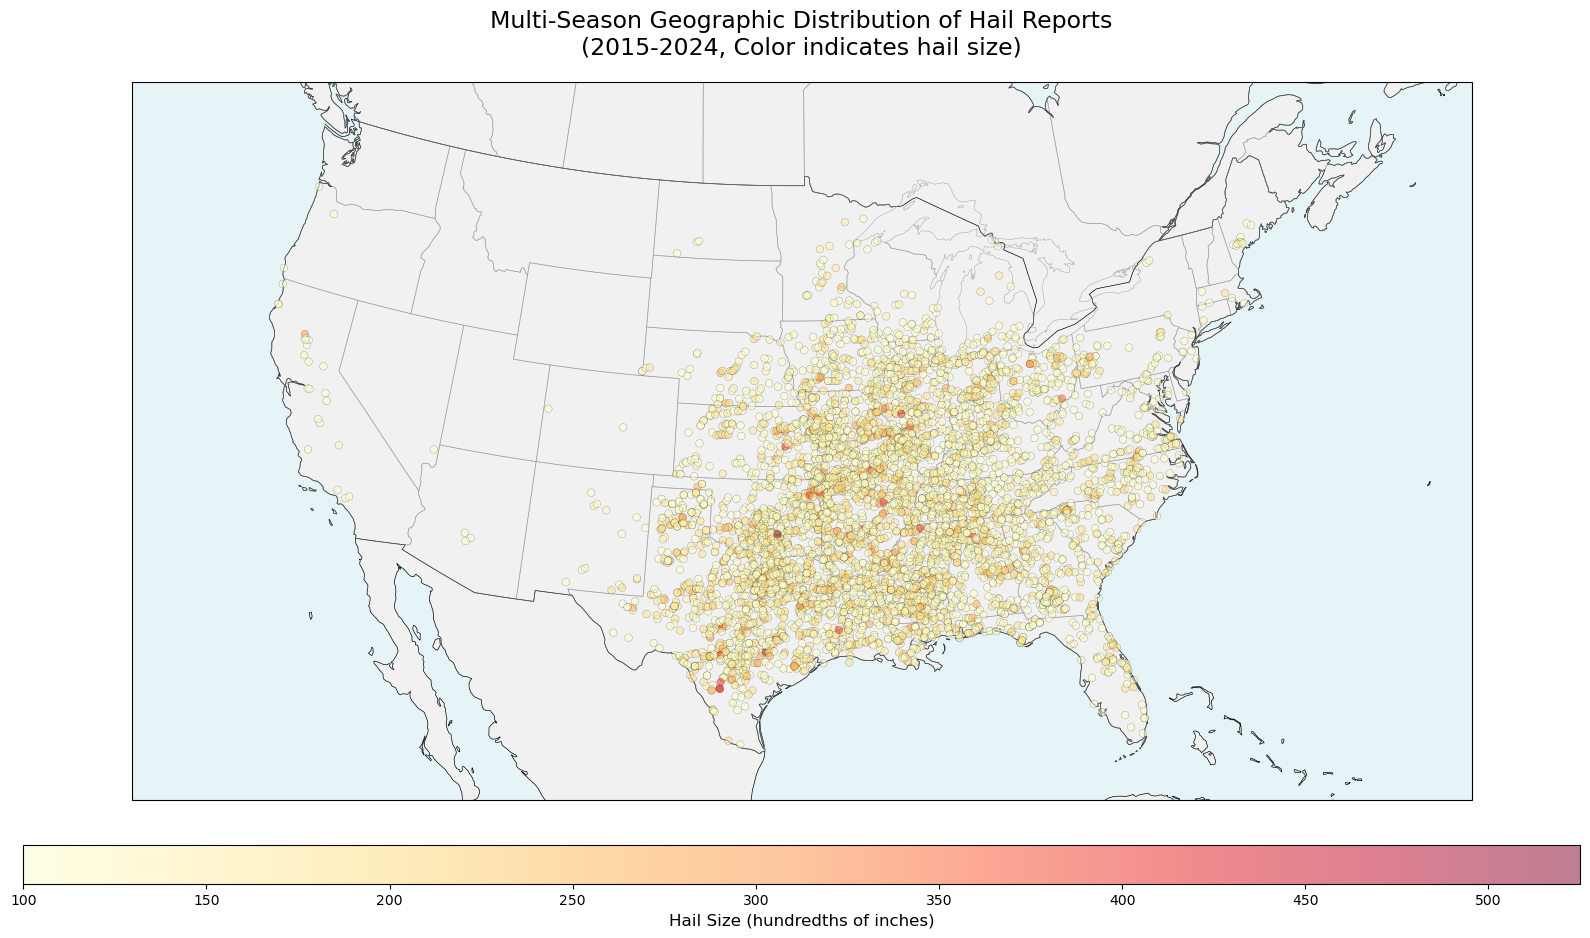

In [36]:
# Geographic scatter plot - All seasons locations colored by hail size (Cartopy map)
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-96, central_latitude=37.5))

# Set extent to cover continental US
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Plot scatter points colored by hail size
scatter = ax.scatter(df_all_seasons['Lon'], df_all_seasons['Lat'], 
                    c=df_all_seasons['Size'], 
                    cmap='YlOrRd', s=30, alpha=0.5, 
                    edgecolors='black', linewidth=0.2,
                    transform=ccrs.PlateCarree(), zorder=10)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
cbar.set_label('Hail Size (hundredths of inches)', fontsize=12)

ax.set_title('Multi-Season Geographic Distribution of Hail Reports\n(2015-2024, Color indicates hail size)', 
            fontsize=17, pad=20)
plt.tight_layout()
plt.show()


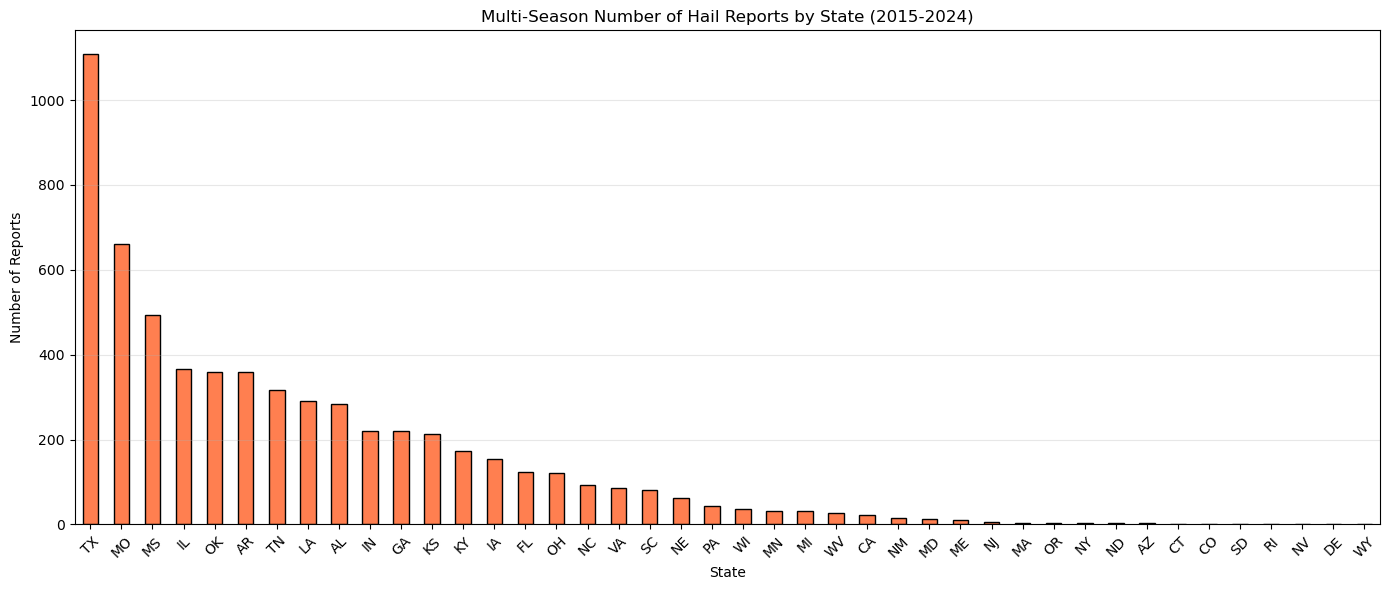

In [37]:
# Reports by state - All seasons
state_counts = df_all_seasons['State'].value_counts()
plt.figure(figsize=(14, 6))
state_counts.plot(kind='bar', color='coral', edgecolor='black')
plt.xlabel('State')
plt.ylabel('Number of Reports')
plt.title('Multi-Season Number of Hail Reports by State (2015-2024)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


### Frequency of Reports/Season

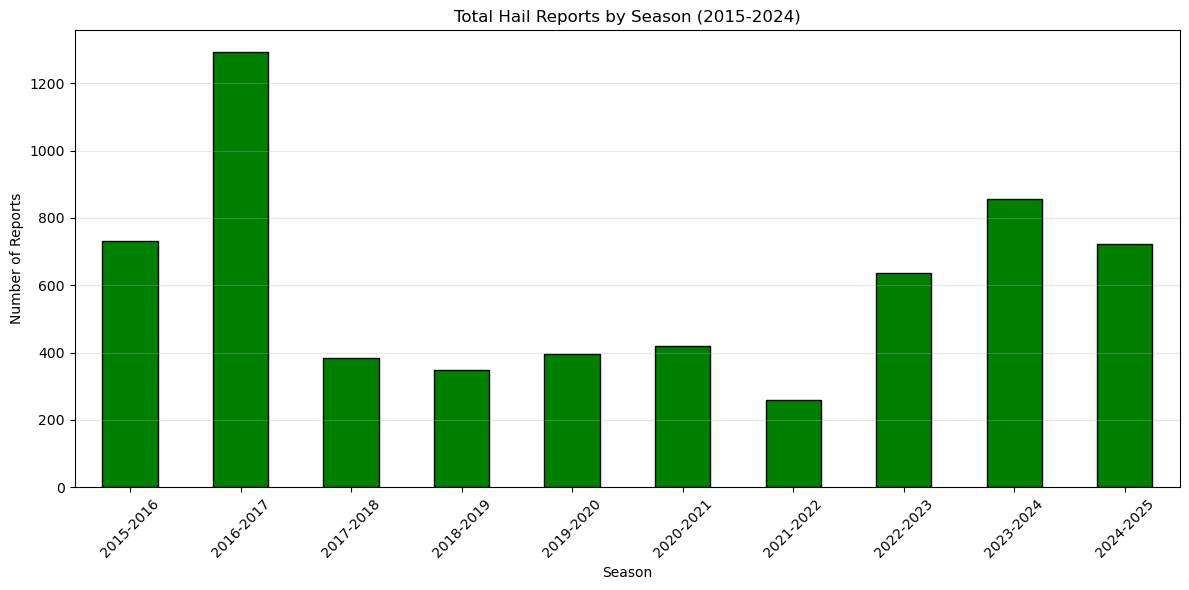

In [38]:
# Reports by season
season_counts = df_all_hail.groupby('Season_Label').size().sort_index()
plt.figure(figsize=(12, 6))
season_counts.plot(kind='bar', color='green', edgecolor='black')
plt.xlabel('Season')
plt.ylabel('Number of Reports')
plt.title('Total Hail Reports by Season (2015-2024)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

### Same figure as above but trying to include all three perils

In [39]:
hail_counts = df_all_hail.groupby('Season_Label').size()
wind_counts = df_all_wind.groupby('Season_Label').size()
tor_counts = df_all_tornado.groupby('Season_Label').size()

In [40]:
season_counts = pd.concat(
    [wind_counts, hail_counts, tor_counts],
    axis=1,
    keys=['Wind', 'Hail','Tornado']
).fillna(0).astype(int).sort_index()

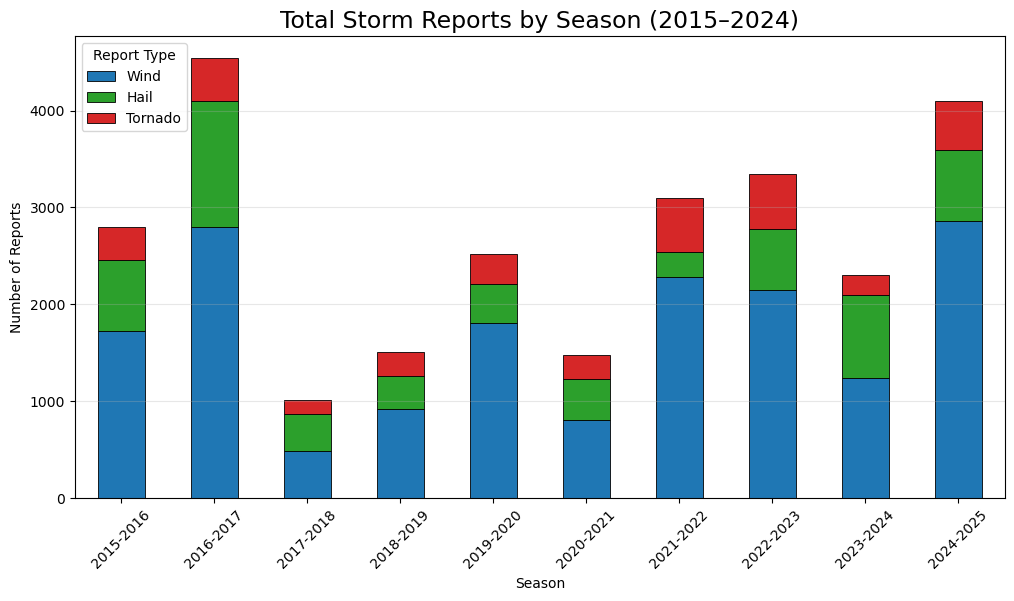

In [41]:
ax = season_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=['tab:blue', 'tab:green', 'tab:red'],
    edgecolor='black',
    linewidth=0.6
)

ax.set_xlabel('Season')
ax.set_ylabel('Number of Reports')
ax.set_title('Total Storm Reports by Season (2015–2024)', fontsize=17)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')
ax.legend(title='Report Type');

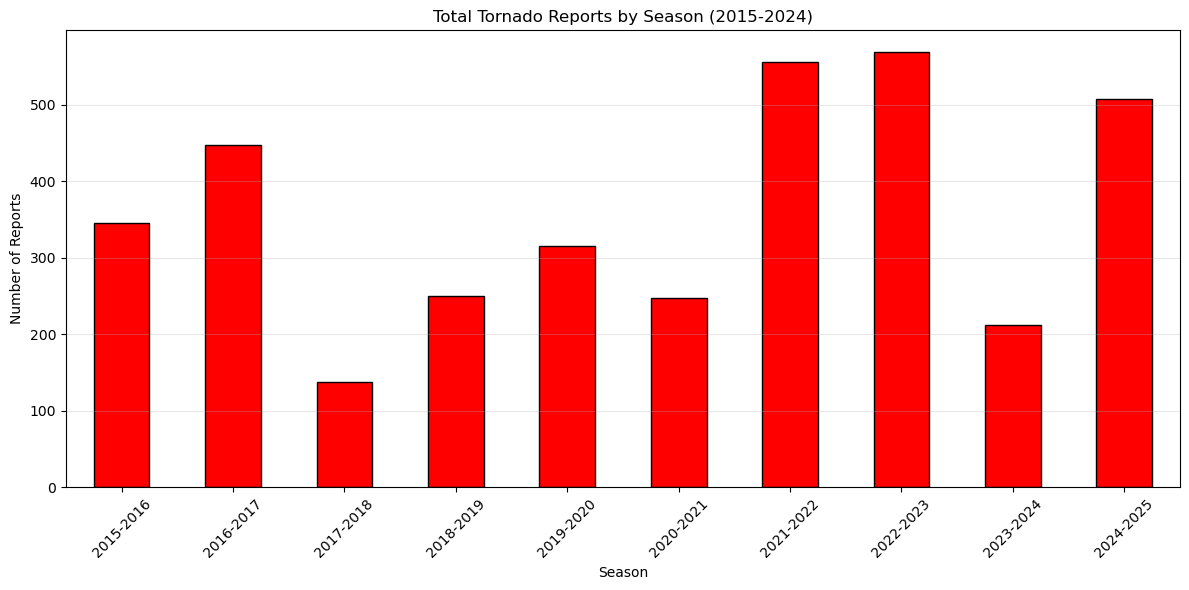

In [42]:
season_counts = df_all_tornado.groupby('Season_Label').size().sort_index()
plt.figure(figsize=(12, 6))
season_counts.plot(kind='bar', color='red', edgecolor='black')
plt.xlabel('Season')
plt.ylabel('Number of Reports')
plt.title('Total Tornado Reports by Season (2015-2024)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

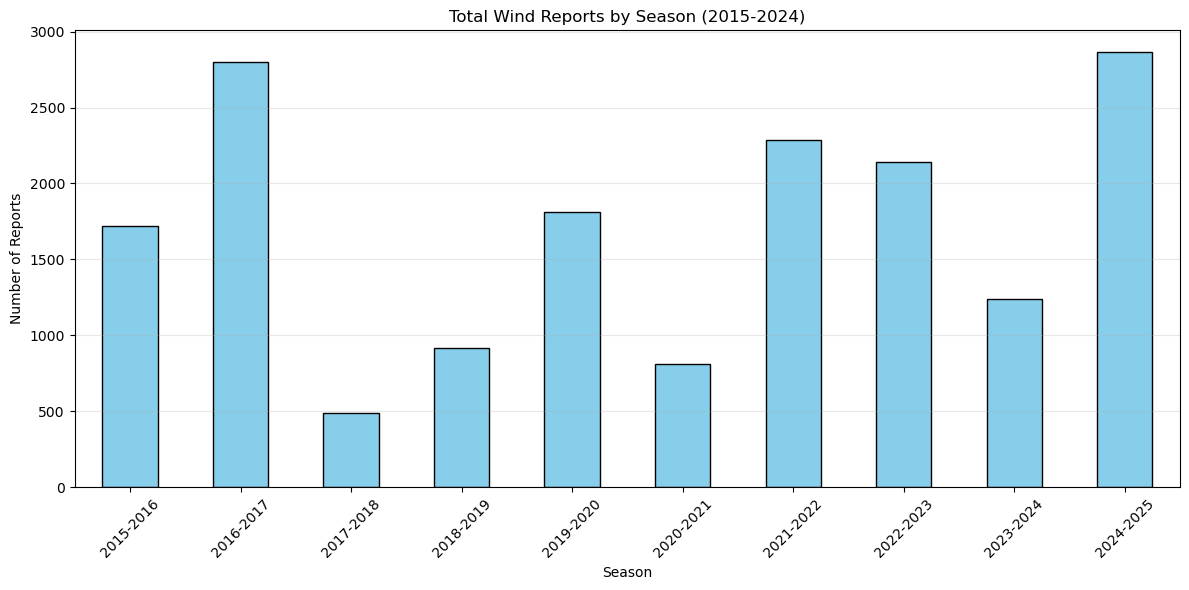

In [43]:
season_counts = df_all_wind.groupby('Season_Label').size().sort_index()
plt.figure(figsize=(12, 6))
season_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Season')
plt.ylabel('Number of Reports')
plt.title('Total Wind Reports by Season (2015-2024)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

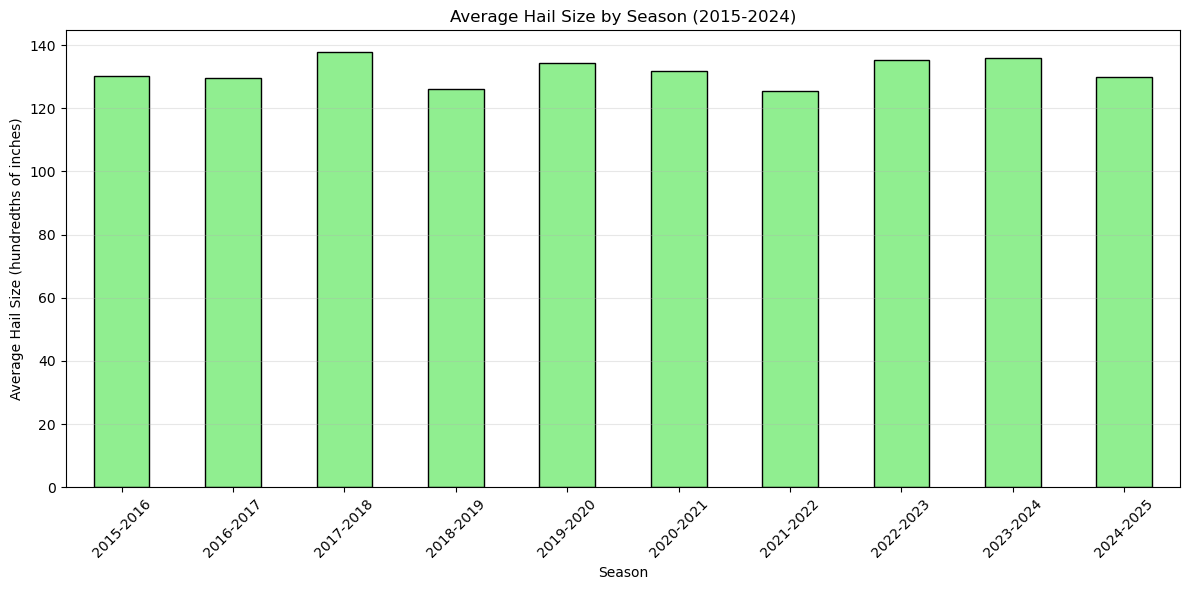

In [44]:
# Average hail size by season
avg_size_by_season = df_all_hail.groupby('Season_Label')['Size'].mean().sort_index()
plt.figure(figsize=(12, 6))
avg_size_by_season.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.xlabel('Season')
plt.ylabel('Average Hail Size (hundredths of inches)')
plt.title('Average Hail Size by Season (2015-2024)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

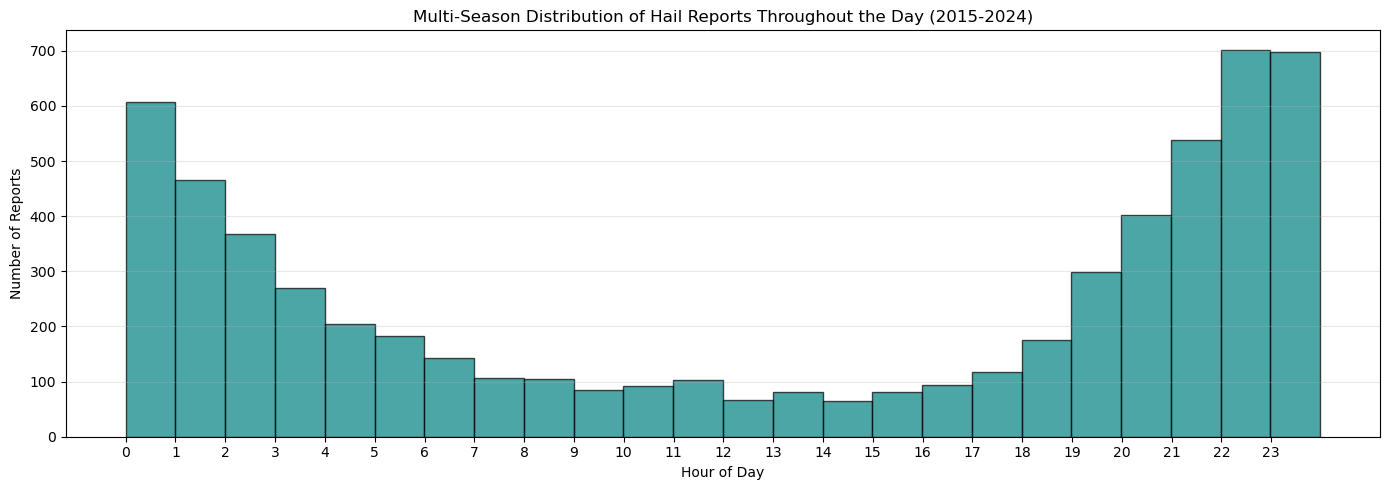

In [45]:
# Time analysis - All seasons
# Convert time to datetime format
df_all_hail['Time_str'] = df_all_hail['Time'].astype(str).str.zfill(4)  # Pad with zeros
df_all_hail['Hour'] = df_all_hail['Time_str'].str[:2].astype(int)
df_all_hail['Minute'] = df_all_hail['Time_str'].str[2:].astype(int)
df_all_hail['Time_of_day'] = df_all_hail['Hour'] + df_all_hail['Minute']/60

# Plot reports by hour of day
plt.figure(figsize=(14, 5))
plt.hist(df_all_hail['Time_of_day'], bins=24, edgecolor='black', alpha=0.7, color='teal')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Reports')
plt.title('Multi-Season Distribution of Hail Reports Throughout the Day (2015-2024)')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

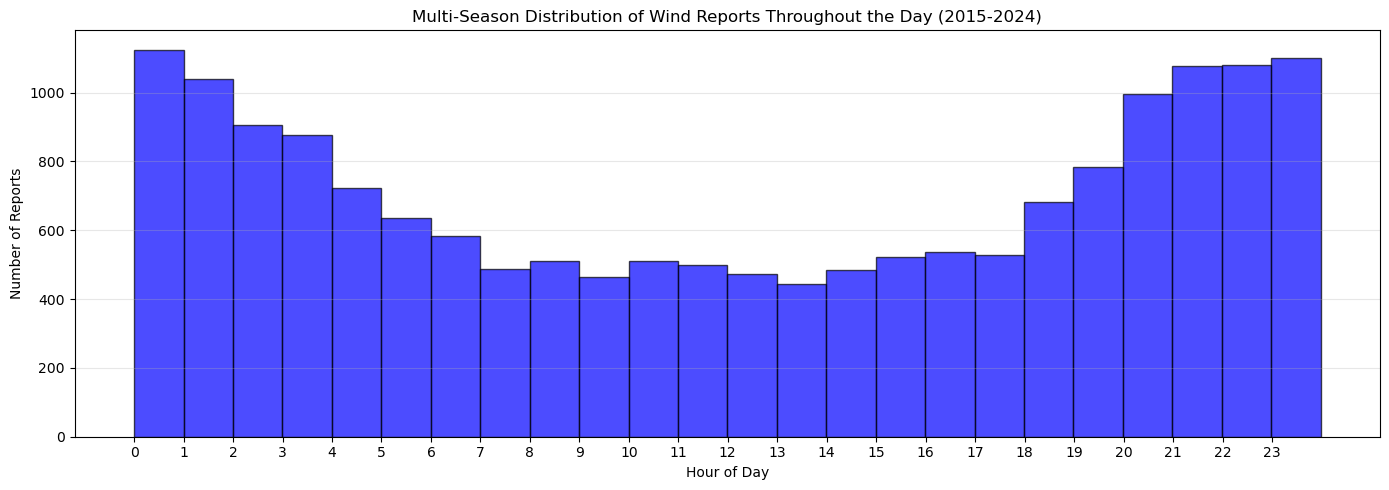

In [46]:
# Time analysis - All seasons
# Convert time to datetime format
df_all_wind['Time_str'] = df_all_wind['Time'].astype(str).str.zfill(4)  # Pad with zeros
df_all_wind['Hour'] = df_all_wind['Time_str'].str[:2].astype(int)
df_all_wind['Minute'] = df_all_wind['Time_str'].str[2:].astype(int)
df_all_wind['Time_of_day'] = df_all_wind['Hour'] + df_all_wind['Minute']/60

# Plot reports by hour of day
plt.figure(figsize=(14, 5))
plt.hist(df_all_wind['Time_of_day'], bins=24, edgecolor='black', alpha=0.7, color='blue')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Reports')
plt.title('Multi-Season Distribution of Wind Reports Throughout the Day (2015-2024)')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

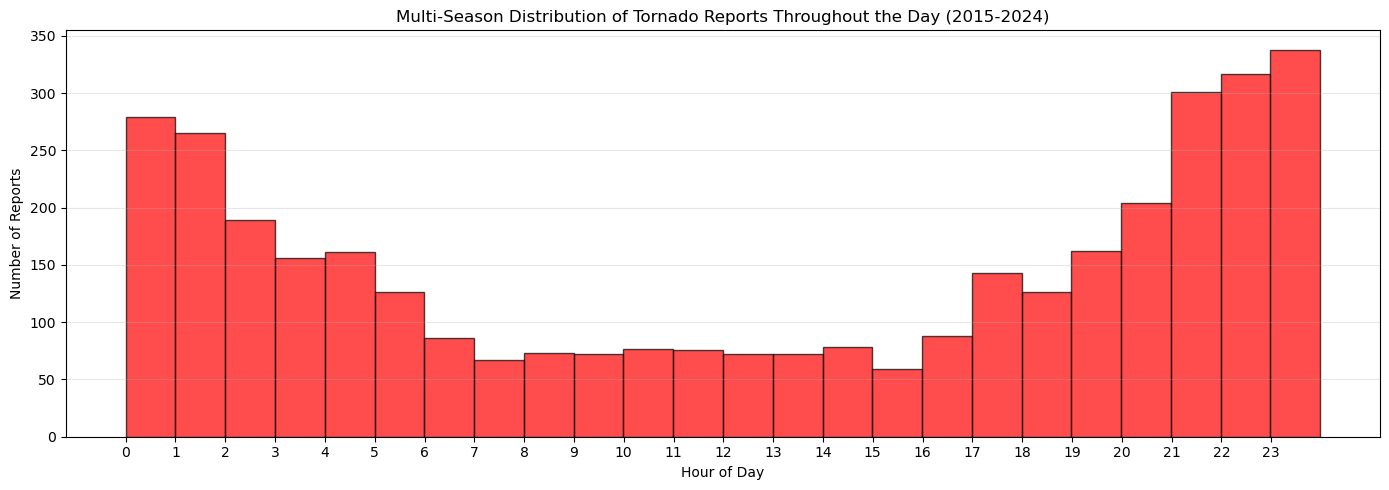

In [47]:
# Time analysis - All seasons
# Convert time to datetime format
df_all_tornado['Time_str'] = df_all_tornado['Time'].astype(str).str.zfill(4)  # Pad with zeros
df_all_tornado['Hour'] = df_all_tornado['Time_str'].str[:2].astype(int)
df_all_tornado['Minute'] = df_all_tornado['Time_str'].str[2:].astype(int)
df_all_tornado['Time_of_day'] = df_all_tornado['Hour'] + df_all_tornado['Minute']/60

# Plot reports by hour of day
plt.figure(figsize=(14, 5))
plt.hist(df_all_tornado['Time_of_day'], bins=24, edgecolor='black', alpha=0.7, color='red')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Reports')
plt.title('Multi-Season Distribution of Tornado Reports Throughout the Day (2015-2024)')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

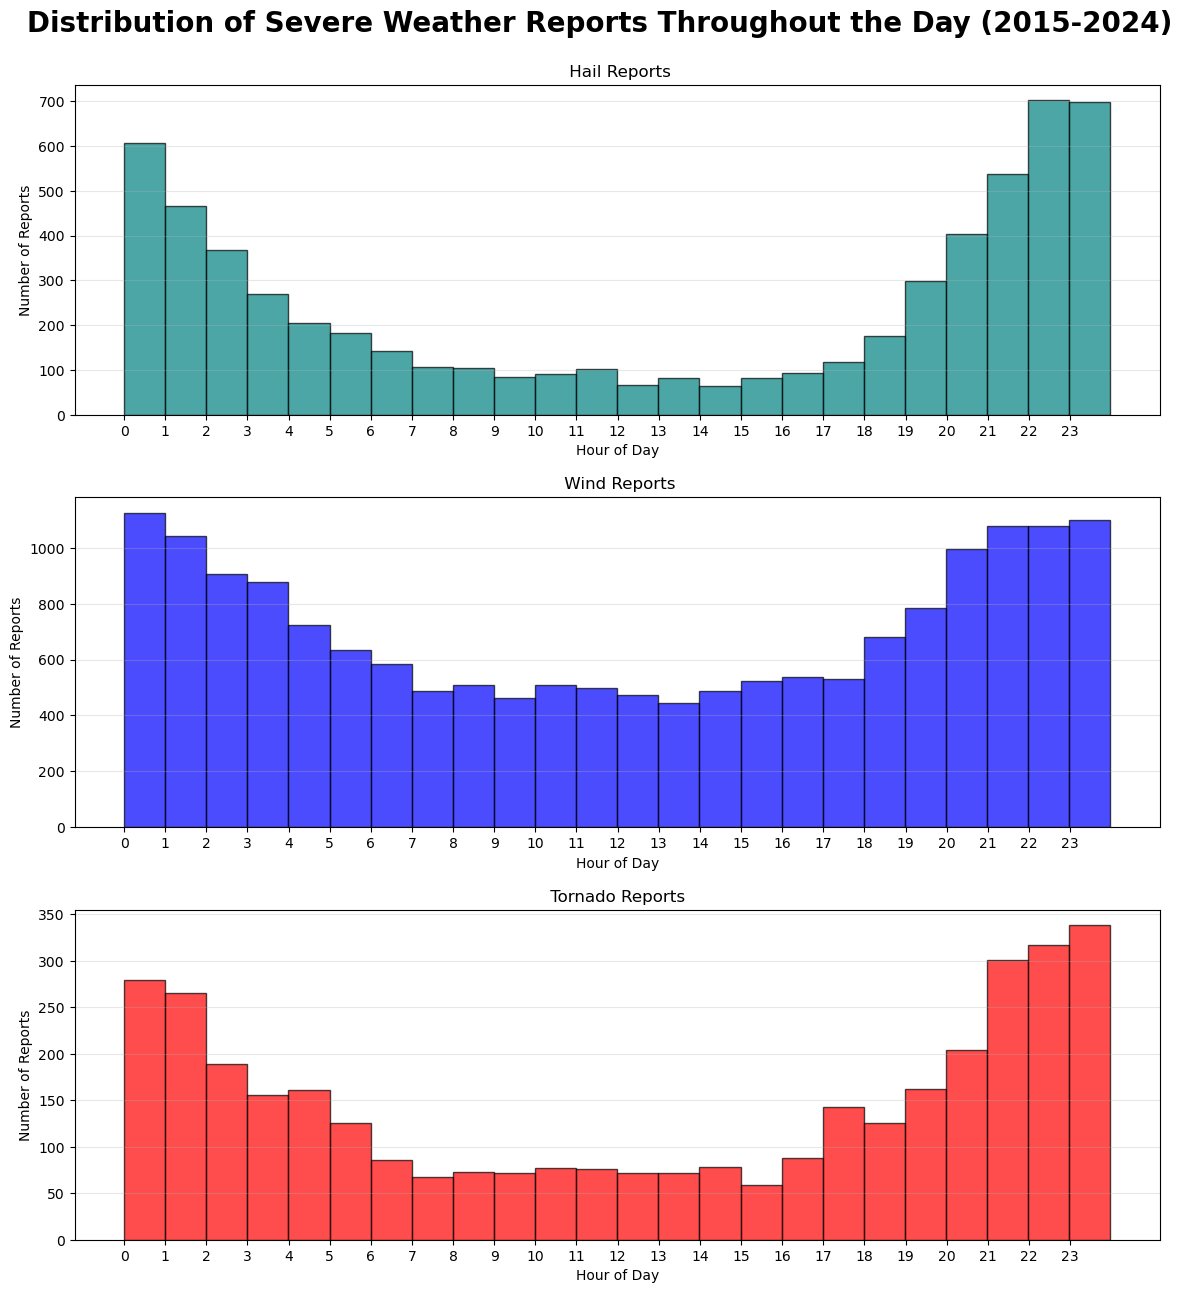

In [48]:
fig, axes = plt.subplots(3,1, figsize = (14,15))

axes[0].hist(df_all_hail['Time_of_day'], bins=24, edgecolor='black', alpha=0.7, color='teal')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Reports')
axes[0].set_title(' Hail Reports')
axes[0].set_xticks(range(0, 24))
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].hist(df_all_wind['Time_of_day'], bins=24, edgecolor='black', alpha=0.7, color='blue')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Number of Reports')
axes[1].set_title(' Wind Reports')
axes[1].set_xticks(range(0, 24))
axes[1].grid(True, alpha=0.3, axis='y')


axes[2].hist(df_all_tornado['Time_of_day'], bins=24, edgecolor='black', alpha=0.7, color='red')
axes[2].set_xlabel('Hour of Day')
axes[2].set_ylabel('Number of Reports')
axes[2].set_title(' Tornado Reports ')
axes[2].set_xticks(range(0, 24))
axes[2].grid(True, alpha=0.3, axis='y')

plt.subplots_adjust(hspace=0.25)
plt.suptitle('Distribution of Severe Weather Reports Throughout the Day (2015-2024)', fontsize=20, fontweight='bold', y=0.93);



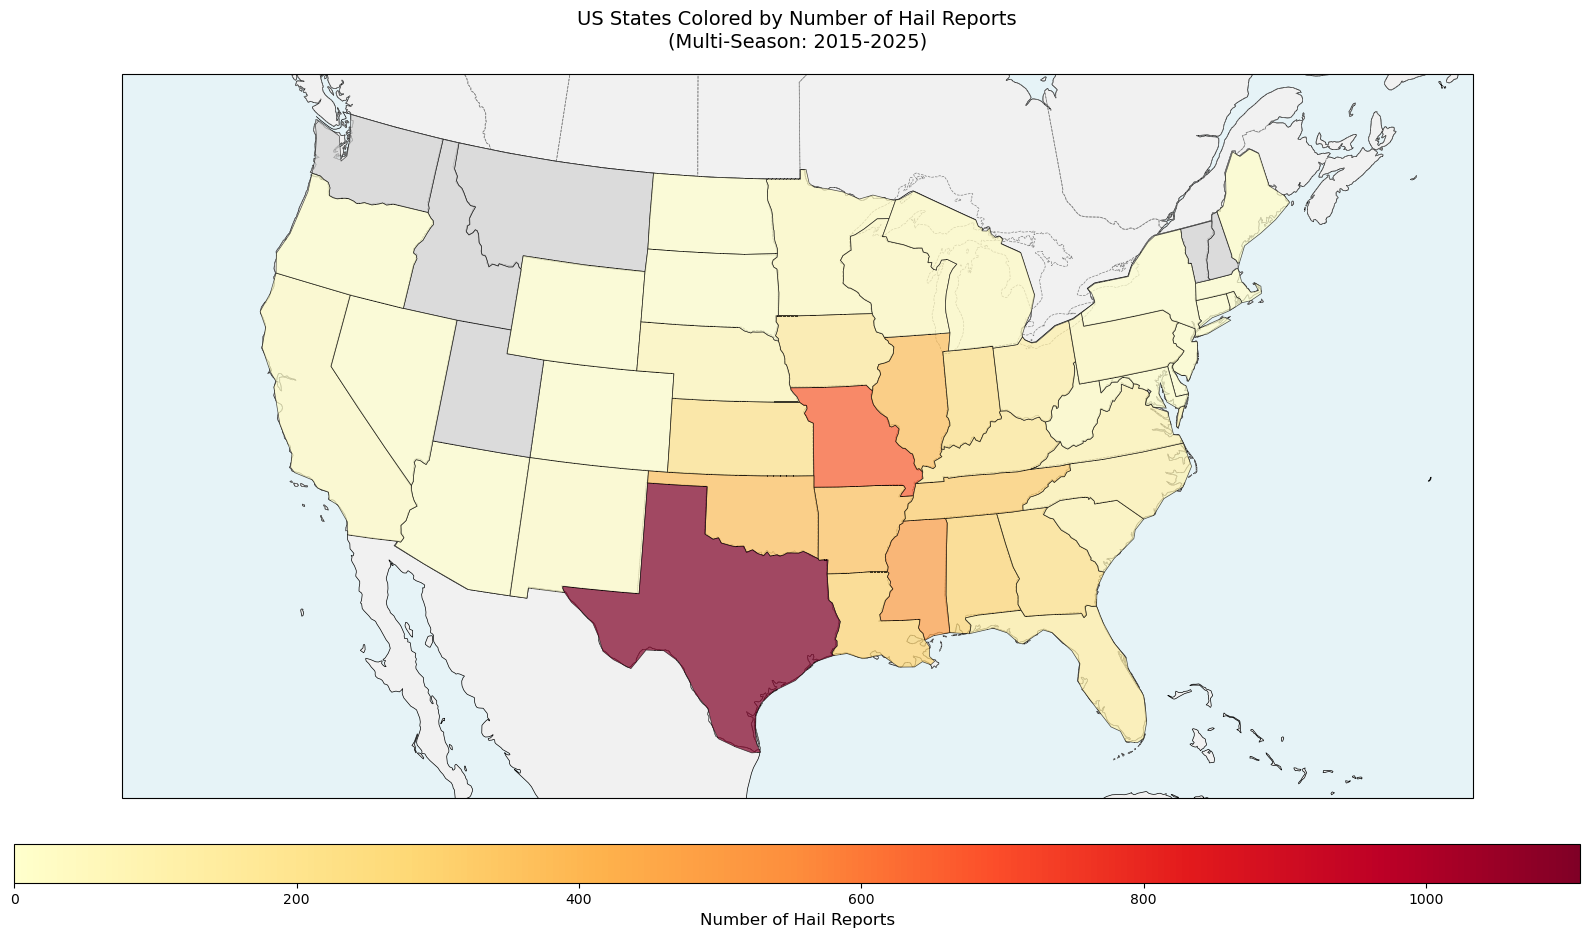

In [49]:
# Cartopy map: US states colored by number of hail reports (All seasons)
# Import shapereader (needed for Natural Earth data)
from cartopy.io import shapereader

# Get report counts by state
state_counts = df_all_seasons['State'].value_counts().to_dict()

# Calculate max reports and colormap before try block (needed in except block too)
max_reports = max(state_counts.values()) if state_counts else 1
cmap = plt.cm.YlOrRd

# Create the map
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-96, central_latitude=37.5))

# Set extent to cover continental US
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', linestyle='--')
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Get state boundaries from Natural Earth
try:
    # Try using Natural Earth states
    # Use full module path to avoid import issues
    import cartopy.io.shapereader as shapereader
    shpfilename = shapereader.natural_earth(resolution='110m', category='cultural', name='admin_1_states_provinces')
    reader = shapereader.Reader(shpfilename)
    states = reader.records()
    
    # State name mapping (Natural Earth uses full names, data uses abbreviations)
    state_abbrev_to_name = {
        'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
        'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
        'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
        'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
        'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
        'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
        'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
        'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
        'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
        'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
    }
    
    # Plot each state
    for state in states:
        state_name = state.attributes.get('name', '')
        state_abbrev = state.attributes.get('postal', '')
        
        # Try to match by abbreviation first, then by name
        report_count = 0
        if state_abbrev in state_counts:
            report_count = state_counts[state_abbrev]
        elif state_name in state_counts:
            report_count = state_counts[state_name]
        elif state_name in state_abbrev_to_name.values():
            # Find abbreviation from name
            for abbrev, name in state_abbrev_to_name.items():
                if name == state_name and abbrev in state_counts:
                    report_count = state_counts[abbrev]
                    break
        
        # Normalize count for coloring (0-1 range)
        if max_reports > 0:
            color_value = report_count / max_reports
        else:
            color_value = 0
        
        # Get color from colormap
        facecolor = cmap(color_value) if report_count > 0 else 'lightgray'
        
        # Plot the state
        ax.add_geometries([state.geometry], ccrs.PlateCarree(),
                         facecolor=facecolor, edgecolor='black', linewidth=0.5, alpha=0.7)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_reports))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Number of Hail Reports', fontsize=12)
    
    ax.set_title('US States Colored by Number of Hail Reports\n(Multi-Season: 2015-2025)', 
                fontsize=14, pad=20)
    
except Exception as e:
    print(f"Error loading Natural Earth data: {e}")
    print("Falling back to simpler visualization...")
    
    # Fallback: Simple map with state boundaries from cartopy
    ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='black')
    
    # Add colorbar for fallback
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_reports))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Number of Hail Reports', fontsize=12)
    
    ax.set_title('US States Colored by Number of Hail Reports\n(Multi-Season: 2015-2024)', 
                fontsize=14, pad=20)

plt.tight_layout()
plt.show()


## Entire time period: 1999-2024

### Load in the Data:

In [4]:
# Load all storm reports (hail, tornado, wind) from all seasons (2015-2024)
# Define season folders
season_folders = ['stormreports_99','stormreports_00','stormreports_01','stormreports_02','stormreports_03''stormreports_04','stormreports_05','stormreports_06','stormreports_07',
                'stormreports_08','stormreports_09','stormreports_10','stormreports_11',
                'stormreports_12','stormreports_13','stormreports_14','stormreports_15',
                'stormreports_16','stormreports_17','stormreports_18','stormreports_19',
                'stormreports_20', 'stormreports_21', 'stormreports_22', 
                'stormreports_23', 'stormreports_24']

# Separate lists for each report type
all_hail_reports = []
all_tornado_reports = []
all_wind_reports = []

for season_folder in season_folders:
    season_path = f'storm_reports/{season_folder}'
    
    # Check if folder exists
    if not os.path.exists(season_path):
        print(f"Warning: {season_path} not found, skipping...")
        continue
    
    # Extract season year from folder name (e.g., stormreports_23 -> 2023, which is Dec 2023)
    # Folder number is the year of December, so stormreports_23 = 2023-2024 season
    season_year = 1900 + int(season_folder[-2:]) if int(season_folder[-2:]) >=90 else 2000 + int(season_folder[-2:])
    
    print(f"\nProcessing {season_folder} (season {season_year}-{season_year+1}):")
    
    # Process each report type
    for report_type in ['hail', 'torn', 'wind']:
        # Get all report files for this type
        if report_type == 'torn':
            pattern = f'{season_path}/*_torn.csv'
        else:
            pattern = f'{season_path}/*_{report_type}.csv'
        
        report_files = glob.glob(pattern)
        report_files.sort()
        
        if not report_files:
            continue
            
        print(f"  Found {len(report_files)} {report_type} report files")
        
        type_reports = []
        for file in report_files:
            # Extract date from filename (format: YYMMDD_rpts_filtered_[type].csv)
            filename = os.path.basename(file)
            date_str = filename[:6]  # First 6 characters are YYMMDD
            
            # Parse date
            #year = 2000 + int(date_str[:2])
            #month = int(date_str[2:4])
            #day = int(date_str[4:6])

            yy = int(date_str[:2])
            year = 1900 + yy if yy >= 90 else 2000 + yy
            
            month = int(date_str[2:4])
            day = int(date_str[4:6])
            
            # Load the CSV
            try:
                # Use engine='python' and on_bad_lines='skip' to handle malformed CSV files
                # (older files have unquoted commas in Comments field)
                try:
                    df_day = pd.read_csv(file, engine='python', on_bad_lines='skip')
                except TypeError:
                    # For older pandas versions that don't have on_bad_lines parameter
                    df_day = pd.read_csv(file, engine='python', error_bad_lines=False, warn_bad_lines=False)
                
                # Add date and season information
                df_day['Date'] = pd.to_datetime(f'{year}-{month:02d}-{day:02d}')
                df_day['Year'] = year
                df_day['Month'] = month
                df_day['Day'] = day
                df_day['Season'] = season_year  # Season year is the December year
                df_day['Season_Label'] = f'{season_year}-{season_year+1}'
                df_day['Report_Type'] = report_type  # Add report type identifier
                df_day['Filename'] = filename
                
                type_reports.append(df_day)
            except Exception as e:
                print(f"    Error loading {filename}: {e}")
                continue
        
        if type_reports:
            df_season_type = pd.concat(type_reports, ignore_index=True)
            
            # Add to appropriate list
            if report_type == 'hail':
                all_hail_reports.append(df_season_type)
            elif report_type == 'torn':
                all_tornado_reports.append(df_season_type)
            elif report_type == 'wind':
                all_wind_reports.append(df_season_type)
            
            print(f"    Total {report_type} reports: {len(df_season_type)}")
            print(f"    Date range: {df_season_type['Date'].min()} to {df_season_type['Date'].max()}")

# Combine all seasons for each report type
if all_hail_reports:
    df_all_hail = pd.concat(all_hail_reports, ignore_index=True)
    print(f"\n{'='*60}")
    print(f"TOTAL HAIL REPORTS ACROSS ALL SEASONS:")
    print(f"Total hail reports: {len(df_all_hail)}")
    print(f"Date range: {df_all_hail['Date'].min()} to {df_all_hail['Date'].max()}")
    print(f"Seasons covered: {sorted(df_all_hail['Season'].unique())}")
else:
    df_all_hail = pd.DataFrame()
    print("\nNo hail reports loaded!")

if all_tornado_reports:
    df_all_tornado = pd.concat(all_tornado_reports, ignore_index=True)
    print(f"\n{'='*60}")
    print(f"TOTAL TORNADO REPORTS ACROSS ALL SEASONS:")
    print(f"Total tornado reports: {len(df_all_tornado)}")
    print(f"Date range: {df_all_tornado['Date'].min()} to {df_all_tornado['Date'].max()}")
    print(f"Seasons covered: {sorted(df_all_tornado['Season'].unique())}")
else:
    df_all_tornado = pd.DataFrame()
    print("\nNo tornado reports loaded!")

if all_wind_reports:
    df_all_wind = pd.concat(all_wind_reports, ignore_index=True)
    print(f"\n{'='*60}")
    print(f"TOTAL WIND REPORTS ACROSS ALL SEASONS:")
    print(f"Total wind reports: {len(df_all_wind)}")
    print(f"Date range: {df_all_wind['Date'].min()} to {df_all_wind['Date'].max()}")
    print(f"Seasons covered: {sorted(df_all_wind['Season'].unique())}")
else:
    df_all_wind = pd.DataFrame()
    print("\nNo wind reports loaded!")

# Also create a combined dataframe with all report types
if not df_all_hail.empty or not df_all_tornado.empty or not df_all_wind.empty:
    all_combined = []
    if not df_all_hail.empty:
        all_combined.append(df_all_hail)
    if not df_all_tornado.empty:
        all_combined.append(df_all_tornado)
    if not df_all_wind.empty:
        all_combined.append(df_all_wind)
    
    if all_combined:
        df_all_storms = pd.concat(all_combined, ignore_index=True)
        print(f"\n{'='*60}")
        print(f"TOTAL ALL STORM REPORTS (HAIL + TORNADO + WIND):")
        print(f"Total reports: {len(df_all_storms)}")
        print(f"Date range: {df_all_storms['Date'].min()} to {df_all_storms['Date'].max()}")
        print(f"Report type breakdown:")
        print(df_all_storms['Report_Type'].value_counts())
        print(f"{'='*60}")
        
        # Keep df_all_seasons for backward compatibility (hail only) so that I don't have to rewrite it all
        df_all_seasons = df_all_hail
    else:
        df_all_storms = pd.DataFrame()
else:
    df_all_storms = pd.DataFrame()
    print("\nNo storm reports loaded!")



Processing stormreports_99 (season 1999-2000):
  Found 46 hail report files
    Total hail reports: 919
    Date range: 1999-12-02 00:00:00 to 2000-03-31 00:00:00
  Found 30 torn report files
    Total torn reports: 198
    Date range: 1999-12-02 00:00:00 to 2000-03-31 00:00:00
  Found 48 wind report files
    Total wind reports: 649
    Date range: 1999-12-02 00:00:00 to 2000-03-31 00:00:00

Processing stormreports_00 (season 2000-2001):
  Found 30 hail report files
    Total hail reports: 329
    Date range: 2000-12-13 00:00:00 to 2001-03-31 00:00:00
  Found 14 torn report files
    Total torn reports: 71
    Date range: 2000-12-14 00:00:00 to 2001-03-29 00:00:00
  Found 44 wind report files
    Total wind reports: 671
    Date range: 2000-12-13 00:00:00 to 2001-03-31 00:00:00

Processing stormreports_01 (season 2001-2002):
  Found 29 hail report files
    Total hail reports: 589
    Date range: 2001-12-05 00:00:00 to 2002-03-31 00:00:00
  Found 15 torn report files
    Total torn r

Dataframes created: 
- `df_all_storms`: all storm reports (hail, wind, tornado) combined
- `df_all_hail`: all hail reports
- `df_all_seasons`: all hail reports (for backend compatibility)
- `df_all_wind`: all wind reports
- `df_all_tornado`: all tornado reports

In [16]:
df_all_tornado.head()

Time F-Scale        Location     County State    Lat    Lon  \
0  1921     UNK      3 E RECTOR       CLAY    AR  36.26 -90.23   
1  1930     UNK       4 N VELMA  YALOBUSHA    MS  34.13 -89.64   
2  1945     UNK     3 E DENMARK  LAFAYETTE    MS  34.31 -89.28   
3  1955     UNK       ITTA BENA    LEFLORE    MS  33.49 -90.33   
4  2003     UNK  5 W NEW ALBANY      UNION    MS  34.49  -89.1   

                                            Comments       Date  Year  Month  \
0  SEVERAL HOMES DAMAGED IN THE COMMUNITY OF HARG... 2000-01-03  2000      1   
1  REPORT OF TORNADO DAMAGE IN THE COMMUNITY OF W... 2000-01-03  2000      1   
2  NUMEROUS TREES BLOWN DOWN AND A ROOF BLOWN OFF... 2000-01-03  2000      1   
3  MOBILE HOME DESTROYED ALONG HIGHWAY 49E NEAR S... 2000-01-03  2000      1   
4  NUMEROUS HOMES DAMAGED OR DESTROYED...MINOR DA... 2000-01-03  2000      1   

   Day  Season Season_Label Report_Type              Filename  Size Speed  \
0    3    1999    1999-2000        torn  000103_rpts_torn.csv   NaN   NaN   
1    3    1999    1999-2000        torn  000103_rpts_torn.csv   NaN   NaN   
2    3    1999    1999-2000        torn  000103_rpts_torn.csv   NaN   NaN   
3    3    1999    1999-2000        torn  000103_rpts_torn.csv   NaN   NaN   
4    3    1999    1999-2000        torn  000103_rpts_torn.csv   NaN   NaN   

  F_Scale  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

### 5-Year Averages:

Here I separate the years into 5 (and a 6) year periods, to see how multi-year averages are trending over the time period

In [5]:
# Calculate average number of storm reports per 5-year period for each peril
# Data spans 20 years (2004-2024), so we'll have 4 five-year periods

# Define 5 (and a 6)-year periods
periods = [
    (1999, 2004, "1999-2004"),
    (2005, 2009, "2004-2009"),
    (2010, 2014, "2010-2014"),
    (2015, 2019, "2015-2019"),
    (2020, 2024, "2020-2024")
]

# Dictionary to store results
results = {
    'Period': [],
    'Hail_Avg': [],
    'Tornado_Avg': [],
    'Wind_Avg': []
}

print("="*70)
print("AVERAGE NUMBER OF STORM REPORTS PER 5-YEAR PERIOD")
print("="*70)
print()

for start_year, end_year, period_label in periods:
    # Filter data for this 5-year period
    if not df_all_hail.empty:
        hail_period = df_all_hail[(df_all_hail['Year'] >= start_year) & (df_all_hail['Year'] <= end_year)]
        hail_count = len(hail_period)
        hail_avg = hail_count / (end_year - start_year + 1)  # Average per year
    else:
        hail_count = 0
        hail_avg = 0
    
    if not df_all_tornado.empty:
        tornado_period = df_all_tornado[(df_all_tornado['Year'] >= start_year) & (df_all_tornado['Year'] <= end_year)]
        tornado_count = len(tornado_period)
        tornado_avg = tornado_count / (end_year - start_year + 1)  # Average per year
    else:
        tornado_count = 0
        tornado_avg = 0
    
    if not df_all_wind.empty:
        wind_period = df_all_wind[(df_all_wind['Year'] >= start_year) & (df_all_wind['Year'] <= end_year)]
        wind_count = len(wind_period)
        wind_avg = wind_count / (end_year - start_year + 1)  # Average per year
    else:
        wind_count = 0
        wind_avg = 0
    
    # Store results
    results['Period'].append(period_label)
    results['Hail_Avg'].append(hail_avg)
    results['Tornado_Avg'].append(tornado_avg)
    results['Wind_Avg'].append(wind_avg)
    
    # Print results for this period
    print(f"Period: {period_label} ({end_year - start_year + 1} years)")
    print(f"  Hail:    {hail_count:>6,} total reports → {hail_avg:>8,.1f} average per year")
    print(f"  Tornado: {tornado_count:>6,} total reports → {tornado_avg:>8,.1f} average per year")
    print(f"  Wind:    {wind_count:>6,} total reports → {wind_avg:>8,.1f} average per year")
    print()

# Create a summary DataFrame
df_period_avg = pd.DataFrame(results)
print("="*70)
print("SUMMARY TABLE")
print("="*70)
print(df_period_avg.to_string(index=False))
print()

# Calculate overall averages across all 20 years
if not df_all_hail.empty:
    total_hail = len(df_all_hail)
    overall_hail_avg = total_hail / 21
else:
    overall_hail_avg = 0

if not df_all_tornado.empty:
    total_tornado = len(df_all_tornado)
    overall_tornado_avg = total_tornado / 21
else:
    overall_tornado_avg = 0

if not df_all_wind.empty:
    total_wind = len(df_all_wind)
    overall_wind_avg = total_wind / 21
else:
    overall_wind_avg = 0

print("="*70)
print("OVERALL AVERAGE (2004-2024, 20 years)")
print("="*70)
print(f"Hail:    {overall_hail_avg:>8,.1f} reports per year")
print(f"Tornado: {overall_tornado_avg:>8,.1f} reports per year")
print(f"Wind:    {overall_wind_avg:>8,.1f} reports per year")
print("="*70)


AVERAGE NUMBER OF STORM REPORTS PER 5-YEAR PERIOD

Period: 1999-2004 (6 years)
  Hail:     2,989 total reports →    498.2 average per year
  Tornado:    467 total reports →     77.8 average per year
  Wind:     2,511 total reports →    418.5 average per year

Period: 2004-2009 (5 years)
  Hail:     5,453 total reports →  1,090.6 average per year
  Tornado:  1,412 total reports →    282.4 average per year
  Wind:     5,963 total reports →  1,192.6 average per year

Period: 2010-2014 (5 years)
  Hail:     3,700 total reports →    740.0 average per year
  Tornado:  1,042 total reports →    208.4 average per year
  Wind:     6,438 total reports →  1,287.6 average per year

Period: 2015-2019 (5 years)
  Hail:     3,117 total reports →    623.4 average per year
  Tornado:  1,293 total reports →    258.6 average per year
  Wind:     6,311 total reports →  1,262.2 average per year

Period: 2020-2024 (5 years)
  Hail:     2,581 total reports →    516.2 average per year
  Tornado:  1,972 total r

### Ploting 5 year averages:

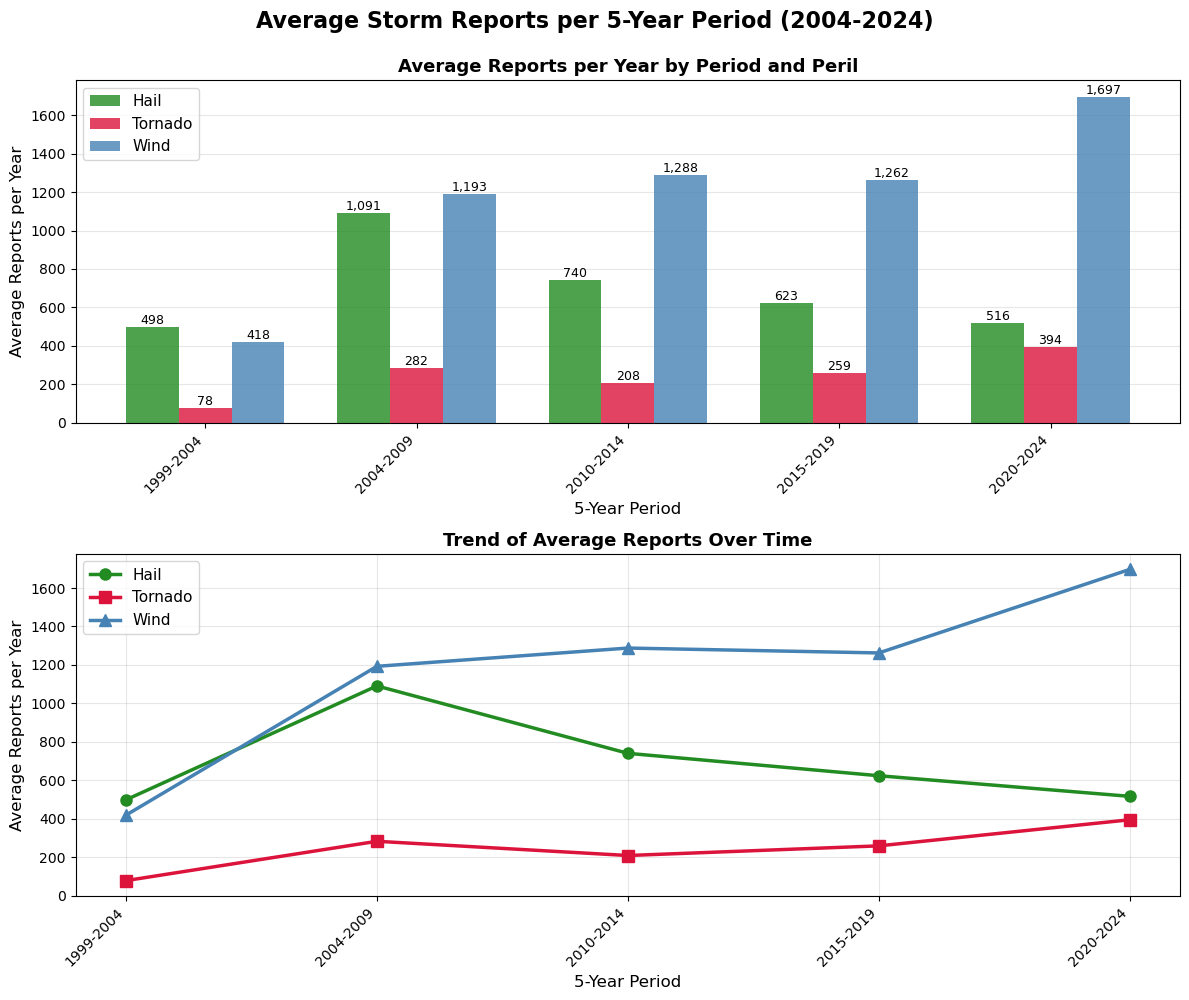

In [21]:
# Visualize average storm reports per 5-year period for each peril

# Create figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(12,10))
fig.suptitle('Average Storm Reports per 5-Year Period (2004-2024)', fontsize=16, fontweight='bold', y=0.995)

# 1. Bar chart comparing all three perils
ax1 = axes[00]
x = np.arange(len(df_period_avg['Period']))
width = 0.25

bars1 = ax1.bar(x - width, df_period_avg['Hail_Avg'], width, label='Hail', color='forestgreen', alpha=0.8)
bars2 = ax1.bar(x, df_period_avg['Tornado_Avg'], width, label='Tornado', color='crimson', alpha=0.8)
bars3 = ax1.bar(x + width, df_period_avg['Wind_Avg'], width, label='Wind', color='steelblue', alpha=0.8)

ax1.set_xlabel('5-Year Period', fontsize=12)
ax1.set_ylabel('Average Reports per Year', fontsize=12)
ax1.set_title('Average Reports per Year by Period and Peril', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_period_avg['Period'], rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_axisbelow(True)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:,.0f}',
                    ha='center', va='bottom', fontsize=9)

# 2. Line plot showing trends over time
ax2 = axes[1]
ax2.plot(df_period_avg['Period'], df_period_avg['Hail_Avg'], marker='o', linewidth=2.5, 
         markersize=8, label='Hail', color='forestgreen')
ax2.plot(df_period_avg['Period'], df_period_avg['Tornado_Avg'], marker='s', linewidth=2.5, 
         markersize=8, label='Tornado', color='crimson')
ax2.plot(df_period_avg['Period'], df_period_avg['Wind_Avg'], marker='^', linewidth=2.5, 
         markersize=8, label='Wind', color='steelblue')

ax2.set_xlabel('5-Year Period', fontsize=12)
ax2.set_ylabel('Average Reports per Year', fontsize=12)
ax2.set_title('Trend of Average Reports Over Time', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_axisbelow(True)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')



plt.tight_layout()
plt.show()


### Average Number of Events per Season:

In [24]:
# Calculate average number of events per season for each report type
print("="*60)
print("AVERAGE EVENTS PER SEASON (1999-2024)")
print("="*60)

# Check if we have data
if not df_all_hail.empty or not df_all_tornado.empty or not df_all_wind.empty:
    # Calculate events per season for each type
    results = {}
    
    if not df_all_hail.empty:
        hail_by_season = df_all_hail.groupby('Season_Label').size()
        avg_hail = hail_by_season.mean()
        results['Hail'] = {
            'per_season': hail_by_season,
            'average': avg_hail,
            'min': hail_by_season.min(),
            'max': hail_by_season.max(),
            'std': hail_by_season.std()
        }
    
    if not df_all_tornado.empty:
        tornado_by_season = df_all_tornado.groupby('Season_Label').size()
        avg_tornado = tornado_by_season.mean()
        results['Tornado'] = {
            'per_season': tornado_by_season,
            'average': avg_tornado,
            'min': tornado_by_season.min(),
            'max': tornado_by_season.max(),
            'std': tornado_by_season.std()
        }
    
    if not df_all_wind.empty:
        wind_by_season = df_all_wind.groupby('Season_Label').size()
        avg_wind = wind_by_season.mean()
        results['Wind'] = {
            'per_season': wind_by_season,
            'average': avg_wind,
            'min': wind_by_season.min(),
            'max': wind_by_season.max(),
            'std': wind_by_season.std()
        }
    
    # Print summary statistics
    print("\nAverage Events Per Season:")
    print("-" * 60)
    for report_type, stats in results.items():
        print(f"\n{report_type}:")
        print(f"  Average: {stats['average']:.1f} events/season")
        print(f"  Minimum: {stats['min']:.0f} events (in a single season)")
        print(f"  Maximum: {stats['max']:.0f} events (in a single season)")
        print(f"  Std Dev: {stats['std']:.1f} events")
        print(f"  Total seasons: {len(stats['per_season'])}")
    
    # Print per-season breakdown
    print("\n" + "="*60)
    print("EVENTS PER SEASON BREAKDOWN:")
    print("="*60)
    
    # Create a comparison table - get all seasons from any available dataframe
    all_seasons_set = set()
    if not df_all_hail.empty:
        all_seasons_set.update(df_all_hail['Season_Label'].unique())
    if not df_all_tornado.empty:
        all_seasons_set.update(df_all_tornado['Season_Label'].unique())
    if not df_all_wind.empty:
        all_seasons_set.update(df_all_wind['Season_Label'].unique())
    all_seasons = sorted(all_seasons_set)
    
    print(f"\n{'Season':<15} {'Hail':<10} {'Tornado':<10} {'Wind':<10} {'Total':<10}")
    print("-" * 60)
    
    for season in all_seasons:
        hail_count = results['Hail']['per_season'].get(season, 0) if 'Hail' in results else 0
        tornado_count = results['Tornado']['per_season'].get(season, 0) if 'Tornado' in results else 0
        wind_count = results['Wind']['per_season'].get(season, 0) if 'Wind' in results else 0
        total = hail_count + tornado_count + wind_count
        
        print(f"{season:<15} {hail_count:<10.0f} {tornado_count:<10.0f} {wind_count:<10.0f} {total:<10.0f}")
    
    # Print averages row
    print("-" * 60)
    avg_hail = results['Hail']['average'] if 'Hail' in results else 0
    avg_tornado = results['Tornado']['average'] if 'Tornado' in results else 0
    avg_wind = results['Wind']['average'] if 'Wind' in results else 0
    avg_total = avg_hail + avg_tornado + avg_wind
    print(f"{'AVERAGE':<15} {avg_hail:<10.1f} {avg_tornado:<10.1f} {avg_wind:<10.1f} {avg_total:<10.1f}")
    print("="*60)
    
else:
    print("No storm report data available for analysis.")

AVERAGE EVENTS PER SEASON (1999-2024)

Average Events Per Season:
------------------------------------------------------------

Hail:
  Average: 771.8 events/season
  Minimum: 198 events (in a single season)
  Maximum: 1809 events (in a single season)
  Std Dev: 443.5 events
  Total seasons: 24

Tornado:
  Average: 272.9 events/season
  Minimum: 43 events (in a single season)
  Maximum: 569 events (in a single season)
  Std Dev: 157.5 events
  Total seasons: 24

Wind:
  Average: 1343.9 events/season
  Minimum: 324 events (in a single season)
  Maximum: 2865 events (in a single season)
  Std Dev: 754.4 events
  Total seasons: 24

EVENTS PER SEASON BREAKDOWN:

Season          Hail       Tornado    Wind       Total     
------------------------------------------------------------
1999-2000       919        198        649        1766      
2000-2001       329        71         671        1071      
2001-2002       589        43         611        1243      
2002-2003       1152       155  

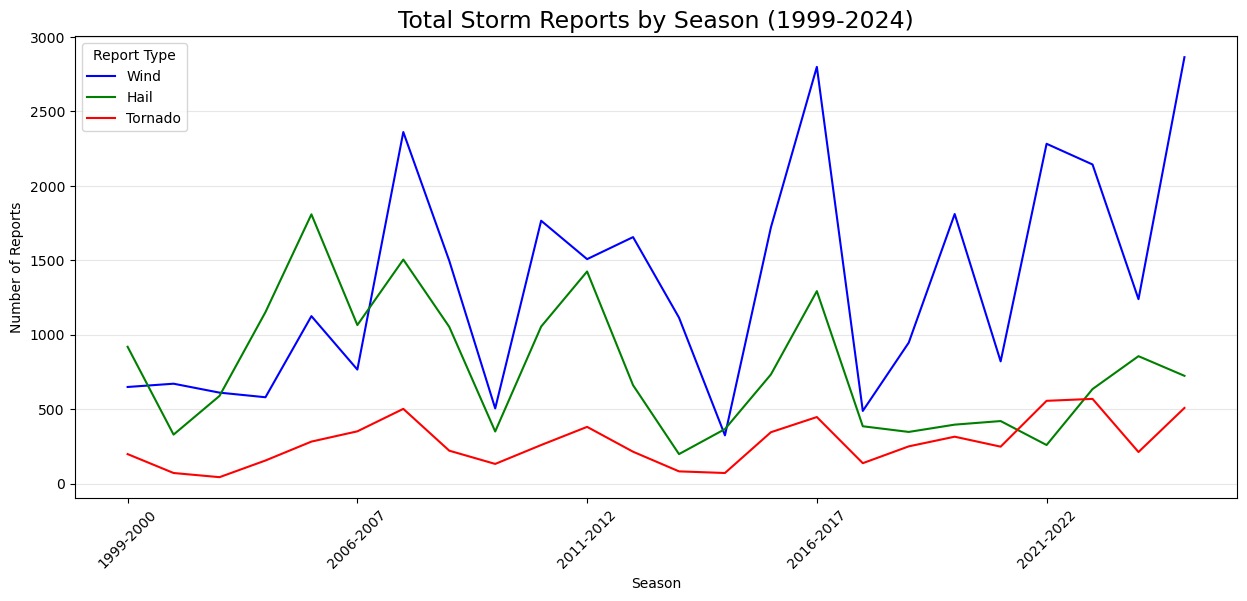

In [23]:
hail_counts = df_all_hail.groupby('Season_Label').size()
wind_counts = df_all_wind.groupby('Season_Label').size()
tor_counts = df_all_tornado.groupby('Season_Label').size()

season_counts = pd.concat(
    [wind_counts, hail_counts, tor_counts],
    axis=1,
    keys=['Wind', 'Hail','Tornado']
).fillna(0).astype(int).sort_index()

ax = season_counts.plot(
    #kind='line',
    #stacked=False,
    figsize=(15, 6),
    color=['blue', 'green', 'red'],
    #edgecolor='black',
    #linewidth=0.6
)

ax.set_xlabel('Season')
ax.set_ylabel('Number of Reports')
ax.set_title('Total Storm Reports by Season (1999-2024)', fontsize=17)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')
ax.legend(title='Report Type');



In [26]:
season_counts.loc['2010-2011']  ###To compare to final storm report data for 2010

Wind       1766
Hail       1055
Tornado     259
Name: 2010-2011, dtype: int64

### Cartopy Plots of Each Peril, categorized by Total Frequency in Each State:

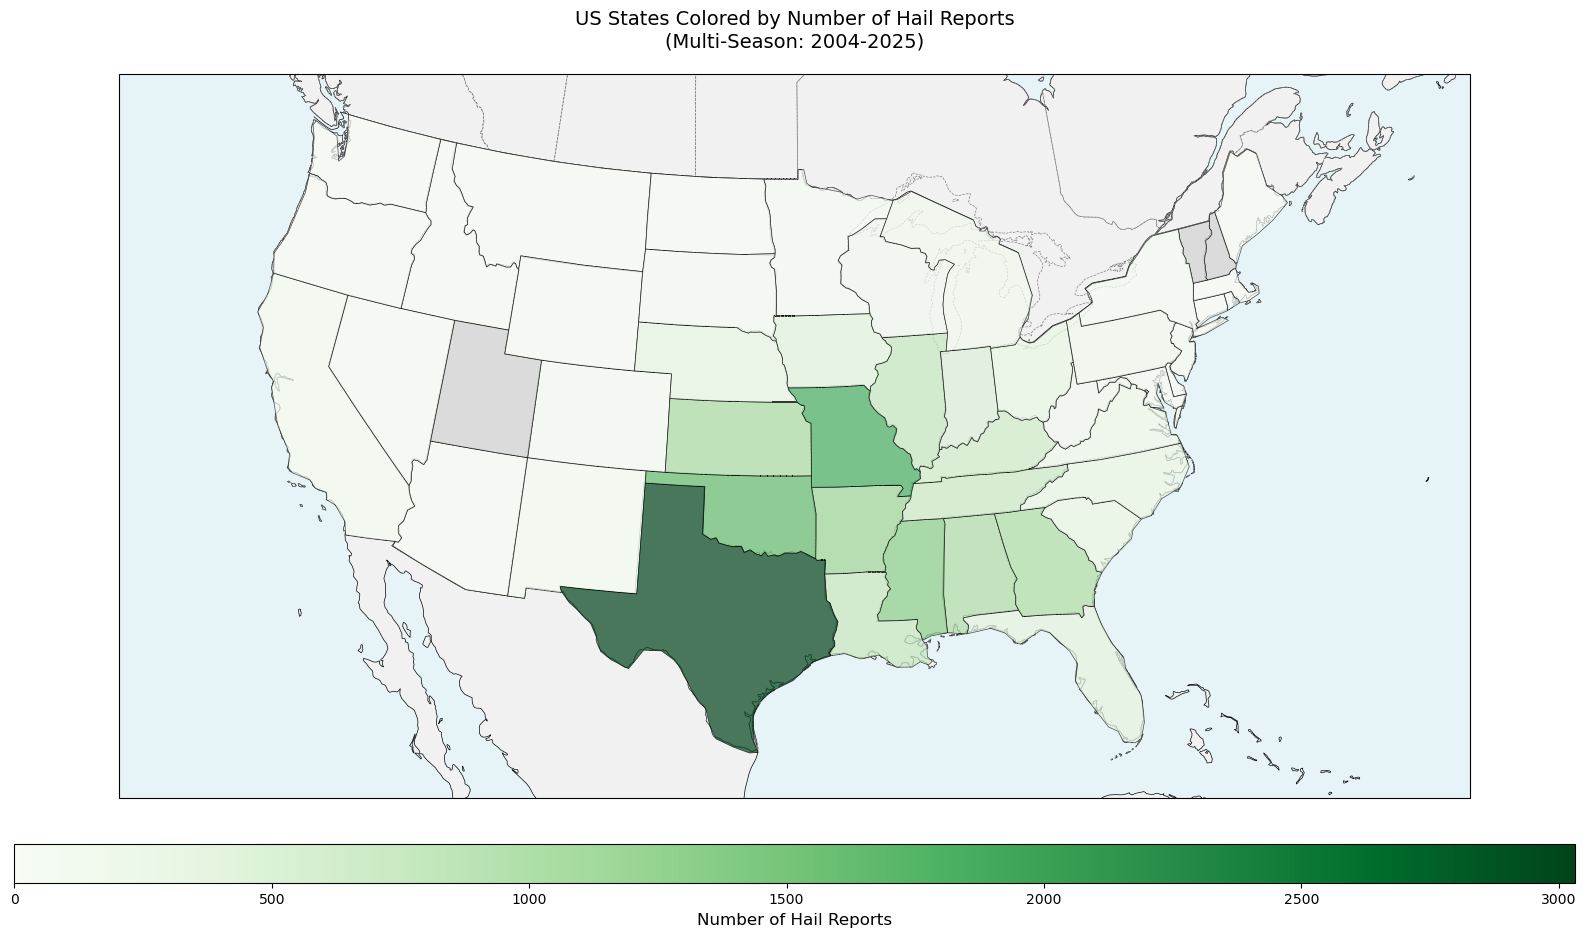

In [31]:
# Cartopy map: US states colored by number of hail reports (All seasons)

# Get report counts by state
state_counts = df_all_hail['State'].value_counts().to_dict()

# Calculate max reports and colormap before try block (needed in except block too)
max_reports = max(state_counts.values()) if state_counts else 1
cmap = plt.cm.Greens

# Create the map
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-96, central_latitude=37.5))

# Set extent to cover continental US
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', linestyle='--')
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Get state boundaries from Natural Earth
try:
    # Try using Natural Earth states
    shpfilename = shapereader.natural_earth(resolution='110m', category='cultural', name='admin_1_states_provinces')
    reader = shapereader.Reader(shpfilename)
    states = reader.records()
    
    # State name mapping (Natural Earth uses full names, data uses abbreviations)
    state_abbrev_to_name = {
        'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
        'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
        'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
        'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
        'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
        'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
        'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
        'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
        'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
        'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
    }
    
    # Plot each state
    for state in states:
        state_name = state.attributes.get('name', '')
        state_abbrev = state.attributes.get('postal', '')
        
        # Try to match by abbreviation first, then by name
        report_count = 0
        if state_abbrev in state_counts:
            report_count = state_counts[state_abbrev]
        elif state_name in state_counts:
            report_count = state_counts[state_name]
        elif state_name in state_abbrev_to_name.values():
            # Find abbreviation from name
            for abbrev, name in state_abbrev_to_name.items():
                if name == state_name and abbrev in state_counts:
                    report_count = state_counts[abbrev]
                    break
        
        # Normalize count for coloring (0-1 range)
        if max_reports > 0:
            color_value = report_count / max_reports
        else:
            color_value = 0
        
        # Get color from colormap
        facecolor = cmap(color_value) if report_count > 0 else 'lightgray'
        
        # Plot the state
        ax.add_geometries([state.geometry], ccrs.PlateCarree(),
                         facecolor=facecolor, edgecolor='black', linewidth=0.5, alpha=0.7)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_reports))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Number of Hail Reports', fontsize=12)
    
    ax.set_title('US States Colored by Number of Hail Reports\n(Multi-Season: 2004-2025)', 
                fontsize=14, pad=20)
    
except Exception as e:
    print(f"Error loading Natural Earth data: {e}")
    print("Falling back to simpler visualization...")
    
    # Fallback: Simple map with state boundaries from cartopy
    ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='black')
    
    # Add colorbar for fallback
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_reports))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Number of Hail Reports', fontsize=12)
    
    ax.set_title('US States Colored by Number of Hail Reports\n(Multi-Season: 1999-2024)', 
                fontsize=14, pad=20)

plt.tight_layout()
plt.show()


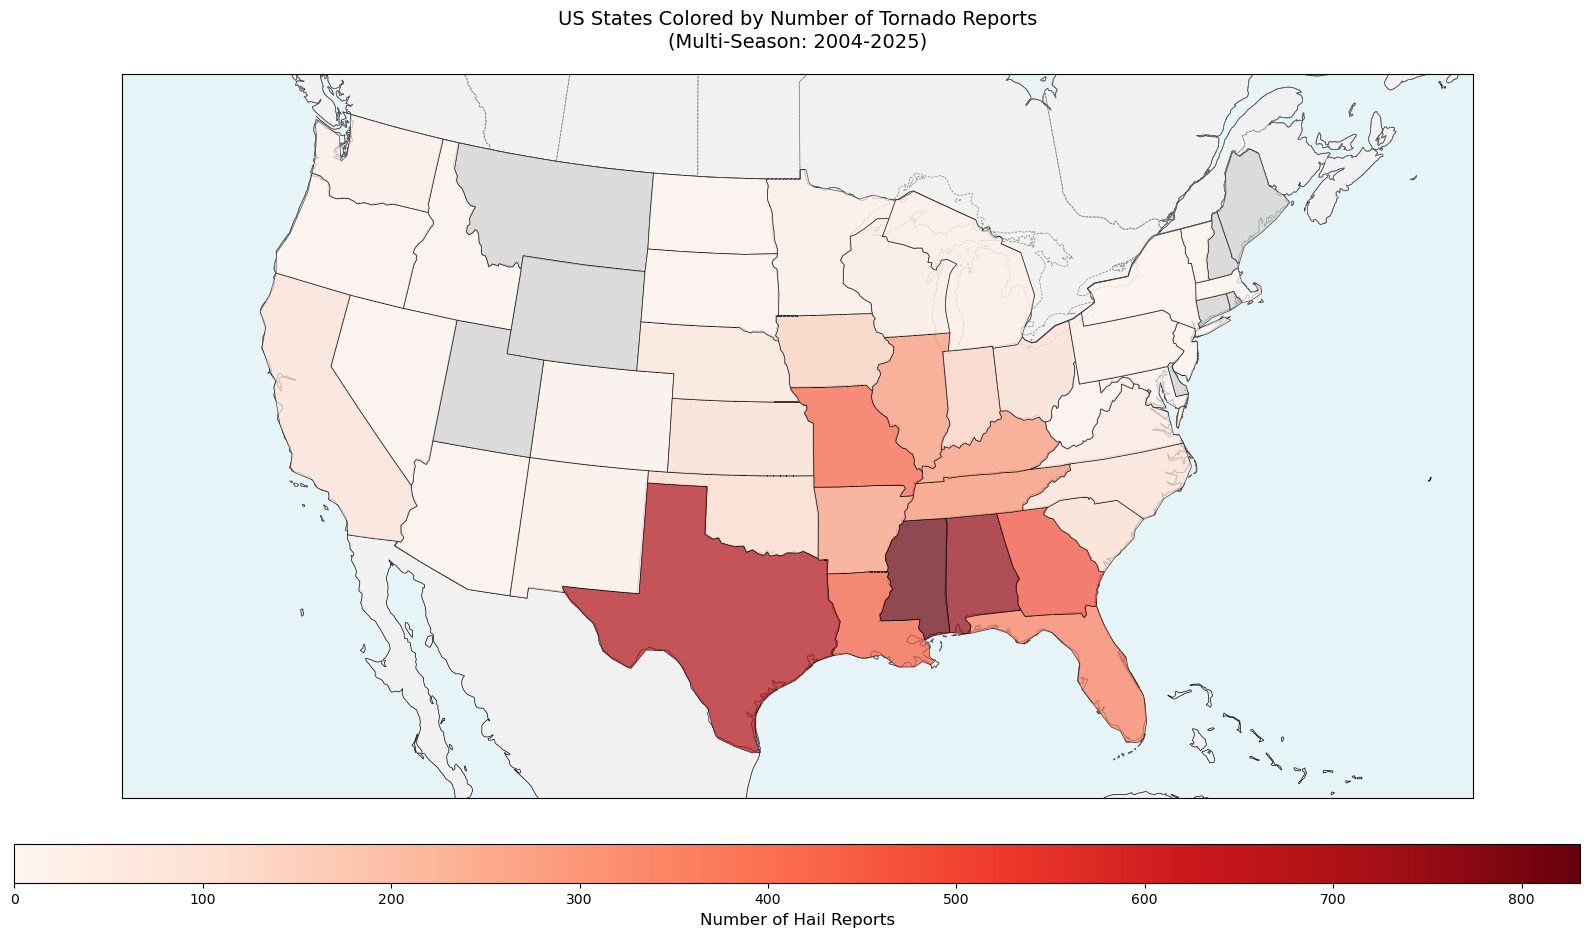

In [32]:
# Cartopy map: US states colored by number of hail reports (All seasons)

# Get report counts by state
state_counts = df_all_tornado['State'].value_counts().to_dict()

# Calculate max reports and colormap before try block (needed in except block too)
max_reports = max(state_counts.values()) if state_counts else 1
cmap = plt.cm.Reds

# Create the map
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-96, central_latitude=37.5))

# Set extent to cover continental US
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', linestyle='--')
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Get state boundaries from Natural Earth
try:
    # Try using Natural Earth states
    shpfilename = shapereader.natural_earth(resolution='110m', category='cultural', name='admin_1_states_provinces')
    reader = shapereader.Reader(shpfilename)
    states = reader.records()
    
    # State name mapping (Natural Earth uses full names, data uses abbreviations)
    state_abbrev_to_name = {
        'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
        'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
        'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
        'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
        'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
        'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
        'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
        'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
        'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
        'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
    }
    
    # Plot each state
    for state in states:
        state_name = state.attributes.get('name', '')
        state_abbrev = state.attributes.get('postal', '')
        
        # Try to match by abbreviation first, then by name
        report_count = 0
        if state_abbrev in state_counts:
            report_count = state_counts[state_abbrev]
        elif state_name in state_counts:
            report_count = state_counts[state_name]
        elif state_name in state_abbrev_to_name.values():
            # Find abbreviation from name
            for abbrev, name in state_abbrev_to_name.items():
                if name == state_name and abbrev in state_counts:
                    report_count = state_counts[abbrev]
                    break
        
        # Normalize count for coloring (0-1 range)
        if max_reports > 0:
            color_value = report_count / max_reports
        else:
            color_value = 0
        
        # Get color from colormap
        facecolor = cmap(color_value) if report_count > 0 else 'lightgray'
        
        # Plot the state
        ax.add_geometries([state.geometry], ccrs.PlateCarree(),
                         facecolor=facecolor, edgecolor='black', linewidth=0.5, alpha=0.7)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_reports))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Number of Hail Reports', fontsize=12)
    
    ax.set_title('US States Colored by Number of Tornado Reports\n(Multi-Season: 2004-2025)', 
                fontsize=14, pad=20)
    
except Exception as e:
    print(f"Error loading Natural Earth data: {e}")
    print("Falling back to simpler visualization...")
    
    # Fallback: Simple map with state boundaries from cartopy
    ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='black')
    
    # Add colorbar for fallback
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_reports))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Number of Hail Reports', fontsize=12)
    
    ax.set_title('US States Colored by Number of Tornado Reports\n(Multi-Season: 2004-2024)', 
                fontsize=14, pad=20)

plt.tight_layout()
plt.show()


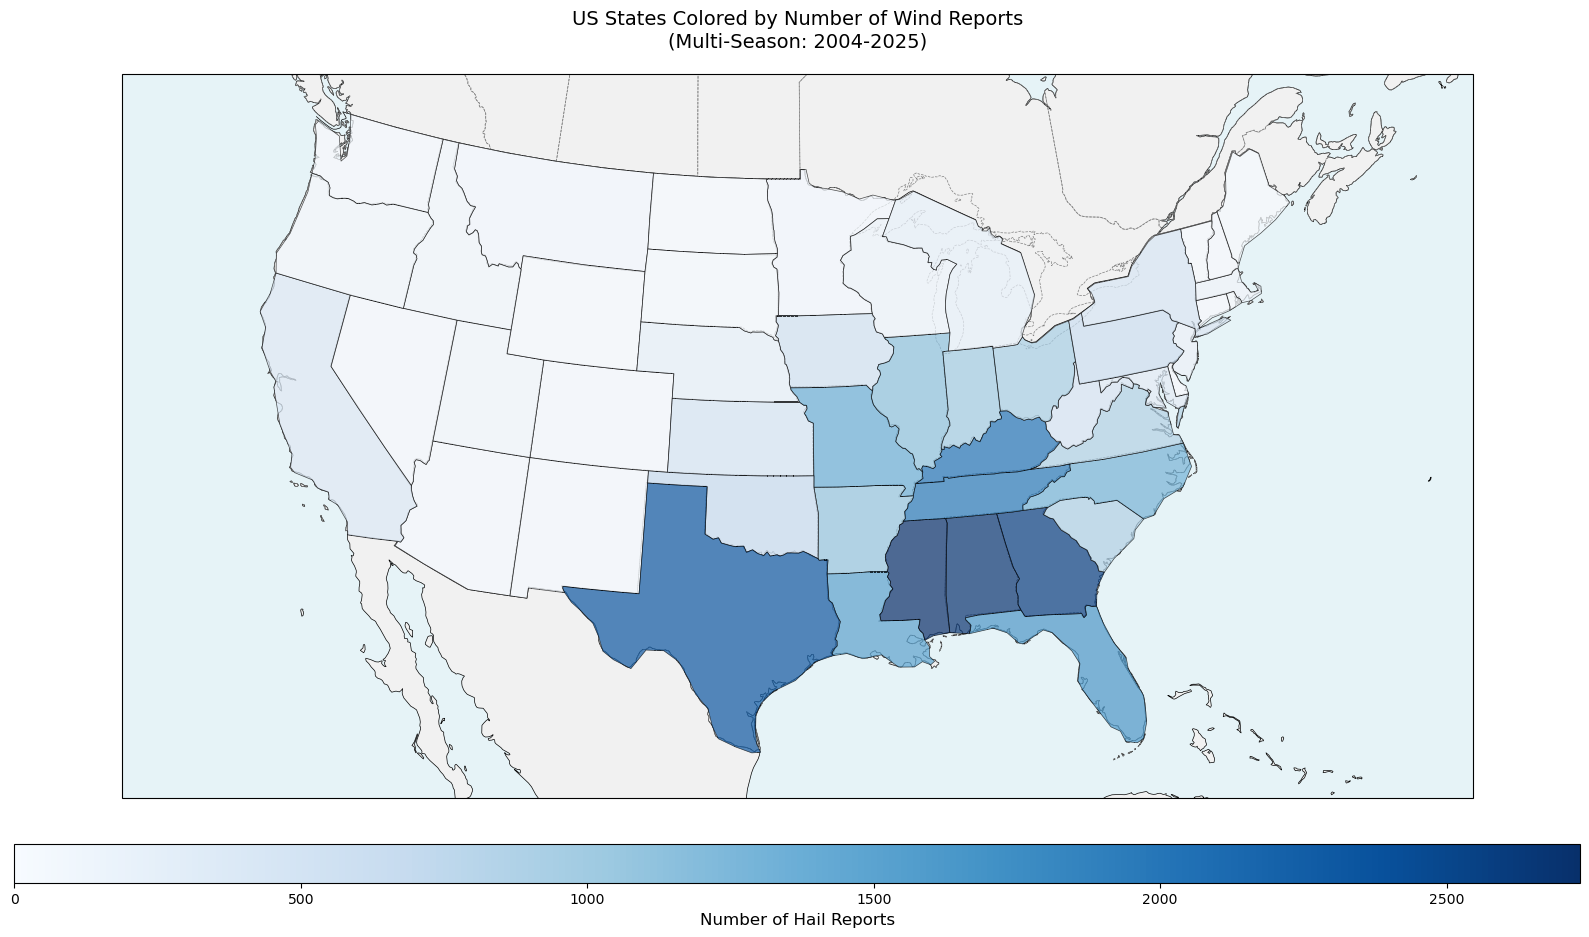

In [33]:
# Cartopy map: US states colored by number of hail reports (All seasons)

# Get report counts by state
state_counts = df_all_wind['State'].value_counts().to_dict()

# Calculate max reports and colormap before try block (needed in except block too)
max_reports = max(state_counts.values()) if state_counts else 1
cmap = plt.cm.Blues

# Create the map
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-96, central_latitude=37.5))

# Set extent to cover continental US
ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', linestyle='--')
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)

# Get state boundaries from Natural Earth
try:
    # Try using Natural Earth states
    shpfilename = shapereader.natural_earth(resolution='110m', category='cultural', name='admin_1_states_provinces')
    reader = shapereader.Reader(shpfilename)
    states = reader.records()
    
    # State name mapping (Natural Earth uses full names, data uses abbreviations)
    state_abbrev_to_name = {
        'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
        'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
        'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
        'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
        'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
        'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
        'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
        'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
        'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
        'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
    }
    
    # Plot each state
    for state in states:
        state_name = state.attributes.get('name', '')
        state_abbrev = state.attributes.get('postal', '')
        
        # Try to match by abbreviation first, then by name
        report_count = 0
        if state_abbrev in state_counts:
            report_count = state_counts[state_abbrev]
        elif state_name in state_counts:
            report_count = state_counts[state_name]
        elif state_name in state_abbrev_to_name.values():
            # Find abbreviation from name
            for abbrev, name in state_abbrev_to_name.items():
                if name == state_name and abbrev in state_counts:
                    report_count = state_counts[abbrev]
                    break
        
        # Normalize count for coloring (0-1 range)
        if max_reports > 0:
            color_value = report_count / max_reports
        else:
            color_value = 0
        
        # Get color from colormap
        facecolor = cmap(color_value) if report_count > 0 else 'lightgray'
        
        # Plot the state
        ax.add_geometries([state.geometry], ccrs.PlateCarree(),
                         facecolor=facecolor, edgecolor='black', linewidth=0.5, alpha=0.7)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_reports))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Number of Hail Reports', fontsize=12)
    
    ax.set_title('US States Colored by Number of Wind Reports\n(Multi-Season: 2004-2025)', 
                fontsize=14, pad=20)
    
except Exception as e:
    print(f"Error loading Natural Earth data: {e}")
    print("Falling back to simpler visualization...")
    
    # Fallback: Simple map with state boundaries from cartopy
    ax.add_feature(cfeature.STATES, linewidth=0.8, edgecolor='black')
    
    # Add colorbar for fallback
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_reports))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Number of Hail Reports', fontsize=12)
    
    ax.set_title('US States Colored by Number of Wind Reports\n(Multi-Season: 2004-2024)', 
                fontsize=14, pad=20)

plt.tight_layout()
plt.show()
